In [656]:
#needed to downgrade xarray to 2023.10.1 version to be compatible with cf_xarray
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as ticker
import regionmask
#import pycno
import geopandas as gpd
from glob import glob
import numpy as np
import os
from netCDF4 import Dataset
from shapely.geometry import Polygon, Point
from global_land_mask import globe
import rasterio
from sklearn.metrics import r2_score
import cf_xarray

#will need to pip install some packages (like cartopy, 

In [426]:
print(os.getcwd())

C:\Users\EMCDUF01\OneDrive - Environmental Protection Agency (EPA)\Documents\CCD-CSIB\GitHub\Code\globalAQ_rft\analysis


In [512]:
#Create 0.5 x0.5 grid (using the globe package)
lat05 = np.arange(-89.75, 90, 0.5)
lon05 = np.arange(-179.75, 180, 0.5)

yp,xp = np.meshgrid(lat05,lon05)
print(yp)       
is_land_vec = np.vectorize(globe.is_land)
landmask2d = is_land_vec(yp,xp)
print(landmask2d)

[[-89.75 -89.25 -88.75 ...  88.75  89.25  89.75]
 [-89.75 -89.25 -88.75 ...  88.75  89.25  89.75]
 [-89.75 -89.25 -88.75 ...  88.75  89.25  89.75]
 ...
 [-89.75 -89.25 -88.75 ...  88.75  89.25  89.75]
 [-89.75 -89.25 -88.75 ...  88.75  89.25  89.75]
 [-89.75 -89.25 -88.75 ...  88.75  89.25  89.75]]
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


In [ ]:
#Create 2x2.5 grid (using the globe package)
lat2 = np.arange(-89, 90, 2)
lon25 = np.arange(-178.75, 180, 2.5)

yp2,xp25 = np.meshgrid(lat2,lon25)
print(yp2)       
is_land_vec = np.vectorize(globe.is_land)
landmask2x25 = is_land_vec(yp2,xp25)
print(np.shape(landmask2x25))
latarray = np.ma.getdata(yp2)
print(np.mean(latarray))

In [692]:
#create usa masks (using the regionmask package)
usa_mask = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
usamask2d = usa_mask.mask(lon05,lat05).transpose()
usamask2d = usamask2d.to_numpy()
usamask2d = np.nan_to_num(usamask2d,0)
usamask2d = usamask2d.astype(bool)
usamask2x25=usa_mask.mask(lon25,lat2).transpose()
usamask2x25=usamask2x25.to_numpy()
usamask2x25 = np.nan_to_num(usamask2x25,0)
usamask2x25 = usamask2x25.astype(bool)

C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2203340446.py:51: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,ozone, vmin=0, vmax=80, snap=True,zorder=2)


(720, 360)
(720, 360)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2203340446.py:51: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,ozone, vmin=0, vmax=80, snap=True,zorder=2)


(720, 360)
(720, 360)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2203340446.py:54: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,data, vmin=-22, vmax=22, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2203340446.py:54: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,data, vmin=-22, vmax=22, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2203340446.py:54: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreas

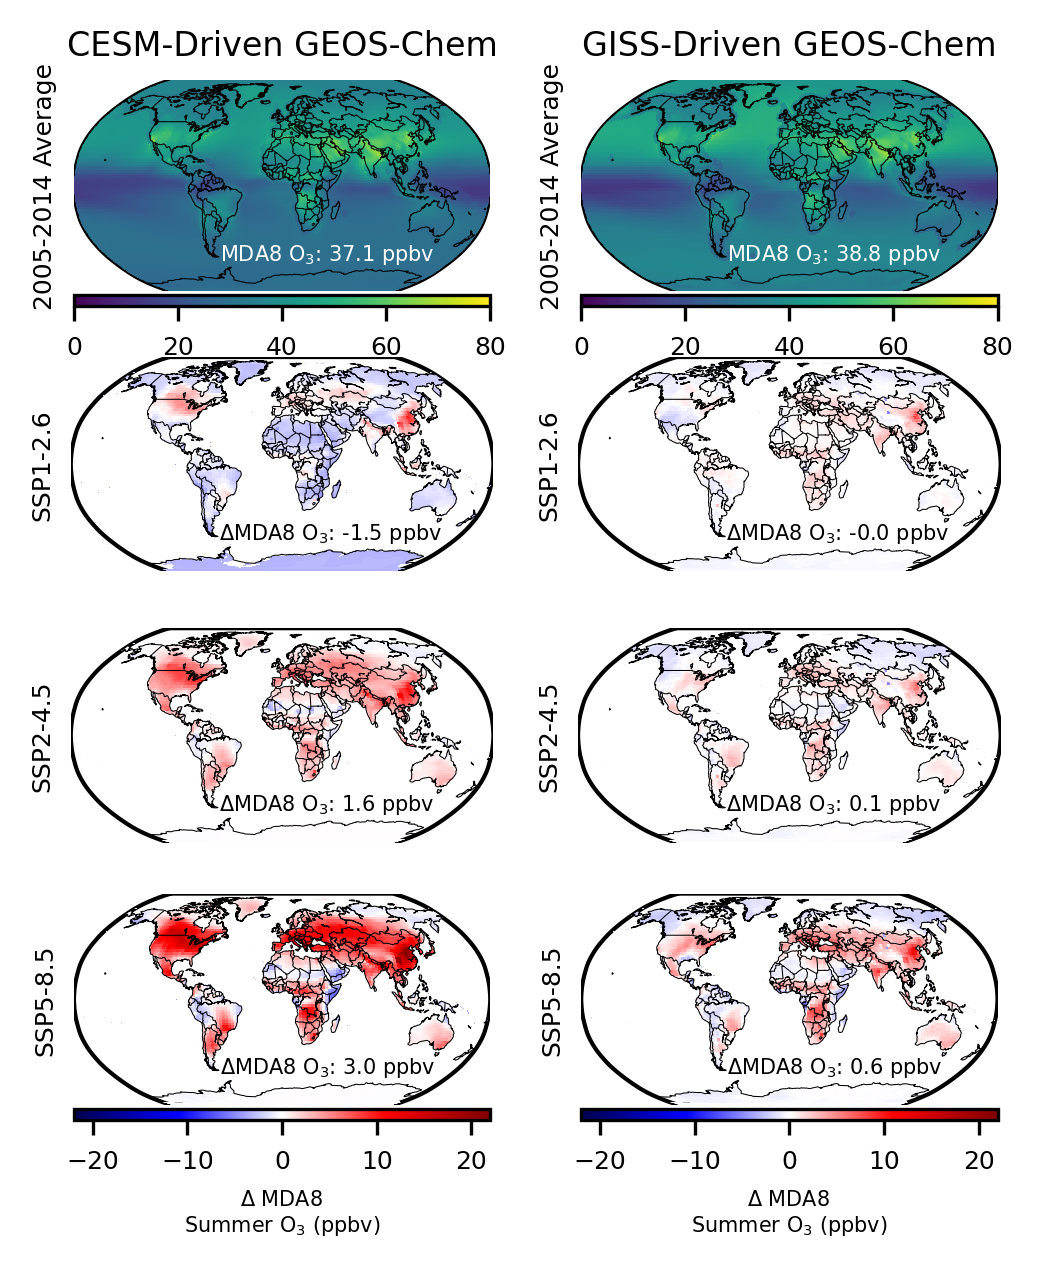

In [428]:
path_iec = 'C:/Users/EMCDUF01/Industrial Economics, Inc/IEc EPA CSIB Share - IEc EPA CSIB Share/03_Global_AQ_Study/Data'
#xrds = xr.open_dataset(path_iec+'/GCAP2-CESM2/OSDMA8.base.nc')

#for attribute, value in xrds.attrs.items():
#    print(attribute, value)

#replace with GISS data when avaialble
# make a plot of O3 data (base in absolute and then delta for other 3 sims)
list_of_files = ['/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.base.nc', '/GCAP2-GISS_Raw Data/Ozone/OSDMA8.base.nc4',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim126.2090s.nc','/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim126.2090s.nc4',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim245.2090s.nc','/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim245.2090s.nc4',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim585.2090s.nc','/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim585.2090s.nc4']


data = Dataset(path_iec+list_of_files[0])
base_ozone_cesm = data.variables['MDA8'][0,0,:,:]
data = Dataset(path_iec+list_of_files[1])
base_ozone_giss = data.variables['corrected'][:,:]

numplts=8
fig = plt.figure(dpi=300,figsize=(4,4.5))

for iplt in np.arange(0,numplts):
    ax = fig.add_subplot(4,2,iplt+1)
    
    data = Dataset(path_iec+list_of_files[iplt])
    lat = data.variables['lat'][:]
    lon = data.variables['lon'][:]
    if ((iplt == 0) ):
        ozone = data.variables['MDA8'][0,0,:,:]
    elif (iplt ==1):
        ozone = data.variables['corrected'][:,:]
    elif ( iplt % 2 == 0):
        ozone = data.variables['MDA8'][0,0,:,:]
        ozone = ozone-base_ozone_cesm
    else:
        ozone = data.variables['corrected'][:,:]
        ozone = ozone-base_ozone_giss
    ozone=ozone.transpose()
    

    #print(ozone)
    m = Basemap(projection='robin',lon_0=0,resolution='c')
    m.drawmapboundary(fill_color='White')
    m.drawcoastlines(linewidth=0.25,zorder=3)
    #m.drawstates(linewidth=0.25,zorder=3)
    m.drawcountries(linewidth=0.25,zorder=3)
    xpi,ypi = m(xp,yp)

    if ((iplt == 0) or (iplt ==1)):
        plot = m.pcolor(xpi,ypi,ozone, vmin=0, vmax=80, snap=True,zorder=2)
    else:
        data = np.ma.array(ozone,mask =~landmask2d)
        plot = m.pcolor(xpi,ypi,data, vmin=-22, vmax=22, snap=True,zorder=2, cmap = 'seismic')
        
    if ((iplt ==0) or (iplt ==1)):
        cb = m.colorbar(plot, location = "bottom", pad = "2%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.set_xlabel('Absolute MDA8 \nSummer O$_3$ (ppbv)',fontsize=5)
    elif ((iplt ==6) or (iplt ==7)):
        cb = m.colorbar(plot, location = "bottom", pad = "2%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.set_xlabel('$\Delta$ MDA8 \nSummer O$_3$ (ppbv)',fontsize=5)
        
    if ((iplt == 0) or (iplt ==1)):
        plt.ylabel('2005-2014 Average',fontsize=6)
    elif iplt % 2 == 0:
        plt.ylabel('SSP'+list_of_files[iplt][45]+'-'+list_of_files[iplt][46]+'.'+list_of_files[iplt][47],fontsize=6)
    else:
        plt.ylabel('SSP'+list_of_files[iplt][38]+'-'+list_of_files[iplt][39]+'.'+list_of_files[iplt][40],fontsize=6)
        
    if ((iplt ==0)):
        ax.set_title('CESM-Driven GEOS-Chem',fontsize=8)
    elif iplt ==1:
        ax.set_title('GISS-Driven GEOS-Chem',fontsize=8)

    cb.ax.tick_params(labelsize=6)
    
    data = ozone
    #print(round(np.mean(np.mean(data)),1))
    data = np.ma.array(data,mask =~landmask2d)
    if ((iplt ==0) or (iplt==1)):
        strtext = 'MDA8 O$_3$: '+ str(round(np.nanmean(np.nanmean(data)),1))+ ' ppbv'
        ax.annotate(strtext, xy=(0.30, 0.15), xycoords='axes fraction', 
               xytext=(0.35, 0.15), textcoords='axes fraction', color='white',fontsize=5)
    else:
        strtext = '$\Delta$MDA8 O$_3$: '+ str(round(np.nanmean(np.mean(data)),1))+ ' ppbv'
        ax.annotate(strtext, xy=(0.3, 0.15), xycoords='axes fraction', 
               xytext=(0.35, 0.15), textcoords='axes fraction', color='black',fontsize=5)
    #print(strtext)
    
    
#ax = plt.axes(projection=ccrs.Robinson())
#ax.contourf(lon,lat,ozone,cmap = 'seismic')

#ax = plt.axes(projection=ccrs.Robinson())
#ax.coastlines()
#ax1.gridlines(draw_labels=True)
plt.savefig('plot_ozone_supplemental.png', bbox_inches='tight')
plt.show();
#print(ozone)
#print(lat)

In [741]:
#calculate land-average MDA8 values
path_iec = 'C:/Users/EMCDUF01/Industrial Economics, Inc/IEc EPA CSIB Share - IEc EPA CSIB Share/03_Global_AQ_Study/Data'

list_of_files = ['/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.base.nc', '/GCAP2-GISS_Raw Data/Ozone/OSDMA8.base.nc4',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim126.2090s.nc','/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim126.2090s.nc4',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim245.2090s.nc','/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim245.2090s.nc4',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim585.2090s.nc','/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim585.2090s.nc4',
                '/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim119.2090s.nc4','/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim434.2090s.nc4',
                '/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim460.2090s.nc4','/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim370.2090s.nc4']
data = Dataset(path_iec+list_of_files[1])
ozone = data.variables['corrected'][:,:]
base_giss = np.ma.array(ozone,mask =~landmaskt)
data = Dataset(path_iec+list_of_files[0])
ozone = data.variables['MDA8'][0,0,:,:]
base_cesm = np.ma.array(ozone,mask =~landmaskt)

for ifile in np.arange(0,len(list_of_files)):
    if 'GISS' in list_of_files[ifile]:
        data = Dataset(path_iec+list_of_files[ifile])
        ozone = data.variables['corrected'][:,:]
        print(np.shape(ozone))
    else:
        data = Dataset(path_iec+list_of_files[ifile])
        ozone = data.variables['MDA8'][0,0,:,:]
        print(np.shape(ozone))

    landmaskt = np.transpose(landmask2d)
    data = np.ma.array(ozone,mask =~landmaskt)
    print(np.shape(landmask2d))
    print(np.shape(landmaskt))

    print('MDA8 land average'+list_of_files[ifile]+': '+str(round(np.nanmean(np.mean(data)),1)))
    if 'GISS' in list_of_files[ifile]:
        print('Min, Mean, Max Change (ppbv): ', str(round(np.min(np.min(data-base_giss)),1)) 
              +', '+str(round(np.mean(np.mean(data-base_giss)),1))
              +', '+str(round(np.max(np.max(data-base_giss)),1)))
    else:
        print('Min, Mean, Max Change (ppbv): ', str(round(np.min(np.min(data-base_cesm)),1)) 
              +', '+str(round(np.mean(np.mean(data-base_cesm)),1))
              +', '+str(round(np.max(np.max(data-base_cesm)),1)))

(360, 720)
(720, 360)
(360, 720)
MDA8 land average/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.base.nc: 37.1
Min, Mean, Max Change (ppbv):  0.0, 0.0, 0.0
(360, 720)
(720, 360)
(360, 720)
MDA8 land average/GCAP2-GISS_Raw Data/Ozone/OSDMA8.base.nc4: 38.8
Min, Mean, Max Change (ppbv):  0.0, 0.0, 0.0
(360, 720)
(720, 360)
(360, 720)
MDA8 land average/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim126.2090s.nc: 35.6
Min, Mean, Max Change (ppbv):  -4.7, -1.5, 9.5
(360, 720)
(720, 360)
(360, 720)
MDA8 land average/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim126.2090s.nc4: 38.7
Min, Mean, Max Change (ppbv):  -5.4, -0.0, 8.2
(360, 720)
(720, 360)
(360, 720)
MDA8 land average/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim245.2090s.nc: 38.7
Min, Mean, Max Change (ppbv):  -4.0, 1.6, 12.0
(360, 720)
(720, 360)
(360, 720)
MDA8 land average/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim245.2090s.nc4: 38.9
Min, Mean, Max Change (ppbv):  -5.3, 0.1, 6.5
(360, 720)
(720, 360)
(360, 720)
MDA8 land average/GCAP2-CESM2_Raw Data/GCA

In [ ]:
# Calculate the change per degree...

#calculate delta ozone for each simulation
# read in the corresponding temperature change
# calculate linear regression between the two

# PM2.5 Maps

In [429]:
# Thos code first loads in the full grid and population array data
# this code needs to combine multiple datasets to create a full grid of global population data that can be used to population-weight PM2.5 results

path_iec = 'C:/Users/EMCDUF01/Industrial Economics, Inc/IEc EPA CSIB Share - IEc EPA CSIB Share/03_Global_AQ_Study/Data/GCAP2-CESM2_Raw Data'
path_iec2 = 'C:/Users/EMCDUF01/Industrial Economics, Inc/IEc EPA CSIB Share - IEc EPA CSIB Share/03_Global_AQ_Study/Data'
#xrds = xr.open_dataset(path_iec+'/GCAP2-CESM2/OSDMA8.base.nc')

#for attribute, value in xrds.attrs.items():
#    print(attribute, value)

#load in Dust and SSA data
data = Dataset(path_iec+'/GCAP2-CESM2/ACAG_PM25_noDUSTnoSEASALT_GWR_V4GL03_0p5_clim.nc')
present_total_PM = data.variables['PM25all'][:,:]
present_base_PM = data.variables['PM25'][:,:]
DSSC = present_total_PM-present_base_PM
print(np.shape(DSSC))
print(np.mean(DSSC))
DSSC = np.nan_to_num(DSSC,nan=0)
print(np.mean(DSSC))

#Make full population grid

# a. read in full grid
data = gpd.read_file(path_iec2+'/Grids/GMA_05x05.shp')
print(np.shape(data))
print(data.crs)
#data already in correct projections (4326 = WGS84)

#read in data where population > 0 
frag_data = gpd.read_file(path_iec2+'/Grids/Final_Fragments_Countries_AQS.shp')
print(np.shape(frag_data))
print(frag_data.crs)
frag_data_wgs84 = frag_data.to_crs({'init': 'epsg:4326'})
print(frag_data_wgs84.crs)
frag_data= frag_data_wgs84.loc[:,["ROW_1",'COL_1','ROW','COL','geometry','Alpha_3_co']]
frag_data.columns = ['ROW','COL','Row','Column','geometry','Alpha_3_co']
print(frag_data.columns)

#read in total population for these grids and merge with fragment grid
pop_data = pd.read_csv(path_iec2+'/RFF Fragment Total Population.csv')
pop_data = pop_data[pop_data.Year==2020.0]
print(pop_data.columns)
full_pop_join = pd.merge(frag_data, pop_data, how = 'left', on=['Row','Column'])
full_pop_join['ROW'] = full_pop_join['ROW'].astype(int)
full_pop_join['COL'] = full_pop_join['COL'].astype(int)
print(np.shape(full_pop_join))
print(full_pop_join.head())
print(full_pop_join.crs)
print(data.head())

#then join the population grid with the full 0.5x0.5 grid
data['ROW'] = data['ROW'].astype(int)
data['COL'] = data['COL'].astype(int)
full_grid_join = pd.merge(data,full_pop_join,how='left', on=['ROW','COL'])
full_grid_join['Year']= full_grid_join['Year'].fillna(2020)
#full_grid_join['total_pop']= full_grid_join['total_pop'].fillna(0)
print(np.shape(full_grid_join))
#print(full_pop_join.head())
print(full_grid_join.head())
print(full_grid_join.columns)
full_grid_join= full_grid_join.set_geometry("geometry_x")

#convert geometry to lat/lon
test = full_grid_join.geometry.bounds
centerx = (test.minx+test.maxx)/2
centery = (test.miny+test.maxy)/2
full_grid_join['Lon'] = centerx
full_grid_join['Lat'] = centery
full_grid_join['total_pop']= full_grid_join['total_pop'].fillna(0)
full_grid_join['World_Pop'] = np.sum(full_grid_join['total_pop'])

#full_grid_join.plot(column='total_pop',cmap='viridis')
#plt.show()

(720, 360)
5.920739170817317
5.920739170817317
(259200, 4)
EPSG:4326
(65156, 37)
EPSG:3857


C:\Users\EMCDUF01\AppData\Local\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


+init=epsg:4326 +type=crs
Index(['ROW', 'COL', 'Row', 'Column', 'geometry', 'Alpha_3_co'], dtype='object')
Index(['Unnamed: 0', 'Column', 'Row', 'Year', 'total_pop'], dtype='object')
(65156, 9)
   ROW  COL     Row  Column  \
0  257  501  501257       4   
1  257  502  502257       4   
2  257  503  503257       4   
3  256  492  492256       4   
4  256  499  499256       4   

                                            geometry Alpha_3_co  Unnamed: 0  \
0  POLYGON ((70.50000 38.00000, 70.30853 38.00000...        AFG      2949.0   
1  POLYGON ((71.00000 38.46050, 71.00000 38.00000...        AFG      3059.0   
2  POLYGON ((71.27455 38.00000, 71.00000 38.00000...        AFG      3158.0   
3  POLYGON ((65.87964 37.50000, 65.66995 37.50000...        AFG      1684.0   
4  POLYGON ((69.50000 37.50000, 69.43228 37.50000...        AFG      2707.0   

     Year     total_pop  
0  2020.0   4309.854968  
1  2020.0  87686.602252  
2  2020.0  35587.885392  
3  2020.0    981.771003  
4  2020.0   25

In [383]:
#This function coverts netCDF files into 1D arrays with lat, lon, values
# 1D arrays are necessary to merge the PM2.5 data with the population data arrays for population weighting

def netcdf_to_points(file_path, variable_name):
    """
    Converts a NetCDF file to a Pandas DataFrame with point data.

    Args:
        file_path (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to extract.

    Returns:
        pandas.DataFrame: DataFrame containing latitude, longitude, and variable values.
    """
    with Dataset(file_path, 'r') as nc_file:
        latitudes = nc_file.variables['lat'][:]
        longitudes = nc_file.variables['lon'][:]
        variable_data = nc_file.variables[variable_name][:]

    if 'GWR_V4GL' in file_path:
        variable_data = np.transpose(variable_data)

    # Create coordinate arrays
    lons, lats = np.meshgrid(longitudes, latitudes)
    
    # Flatten the data and coordinates
    points = pd.DataFrame({
        'Lat': lats.flatten(),
        'Lon': lons.flatten(),
        variable_name: variable_data.flatten()
    })
    return points

In [386]:
# read in base PM2.5 and Dust, and convert to points
allPM_df = netcdf_to_points(path_iec+'/GCAP2-CESM2/ACAG_PM25_noDUSTnoSEASALT_GWR_V4GL03_0p5_clim.nc', 'PM25all')
basePM_df = netcdf_to_points(path_iec+'/GCAP2-CESM2/ACAG_PM25_noDUSTnoSEASALT_GWR_V4GL03_0p5_clim.nc', 'PM25')
basePM_df['DST_SSA'] = allPM_df.loc[:,'PM25all']- basePM_df.loc[:,'PM25']
basePM_df['PM25all'] = allPM_df.loc[:,'PM25all']


#print(full_grid_join)
full_data_join = pd.merge(full_grid_join,basePM_df,how='left', on=['Lat','Lon'])
full_data_join['PW_PM25'] = np.sum((full_data_join.loc[:,'total_pop']*full_data_join.loc[:,'PM25all']))/full_data_join.loc[:,'World_Pop']
#print(full_data_join)
print(np.mean(full_data_join['PW_PM25'])) #just to double check Satellite-derived Population-weighting

#basePM_df.plot(column='PM25',cmap='viridis')
#plt.show()

33.27464607084201


In [447]:
path_iec = 'C:/Users/EMCDUF01/Industrial Economics, Inc/IEc EPA CSIB Share - IEc EPA CSIB Share/03_Global_AQ_Study/Data'

#replace with GISS data when avaialble
# make a plot of PM2.5 data (base in absolute and then delta for other 3 sims)
list_of_files = ['/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.base.nc', '/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.base.nc',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.clim126.2090s.nc','/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim126.2090s.nc',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.clim245.2090s.nc','/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim245.2090s.nc',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.clim585.2090s.nc','/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim585.2090s.nc',
                '/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim119.2090s.nc','/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim434.2090s.nc',
                '/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim460.2090s.nc','/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim370.2090s.nc']
data = Dataset(path_iec+list_of_files[0])
base_PM_cesm = data.variables['PM25'][0,0,:,:]
#print(np.shape(base_PM_cesm))
data = Dataset(path_iec+list_of_files[1])
base_PM_giss = data.variables['PM25'][0,0,:,:]
#print(np.shape(base_PM_giss))
#print(np.shape(landmask2d))
#print(np.mean(base_PM_cesm))
#print(np.mean(base_PM_giss))

for ifile in np.arange(0,len(list_of_files)):
    data_df = netcdf_to_points(path_iec+list_of_files[ifile],'PM25')
    data_df['PM25'] = data_df.loc[:,'PM25']+basePM_df.loc[:,'DST_SSA']
    full_data_join = pd.merge(full_grid_join,data_df,how='left', on=['Lat','Lon'])
    full_data_join['PW_PM25'] = np.sum((full_data_join.loc[:,'total_pop']*full_data_join.loc[:,'PM25']))/full_data_join.loc[:,'World_Pop']

    print('Population-weighted annual average'+list_of_files[ifile]+': '+str(round(np.nanmean(np.mean(full_data_join['PW_PM25'])),1)))

Population-weighted annual average/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.base.nc: 33.3
Population-weighted annual average/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.base.nc: 33.3
Population-weighted annual average/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.clim126.2090s.nc: 31.6
Population-weighted annual average/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim126.2090s.nc: 31.9
Population-weighted annual average/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.clim245.2090s.nc: 31.6
Population-weighted annual average/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim245.2090s.nc: 31.9
Population-weighted annual average/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.clim585.2090s.nc: 31.4
Population-weighted annual average/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim585.2090s.nc: 31.6
Population-weighted annual average/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim119.2090s.nc: 32.0
Population-weighted annual average/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim434.2090s.nc: 32.4
Populati

(360, 720)
(720, 360)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1018719365.py:52: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,PM, vmin=0, vmax=100, snap=True,zorder=2)
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1018719365.py:52: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,PM, vmin=0, vmax=100, snap=True,zorder=2)


(360, 720)
(720, 360)
(360, 720)
(720, 360)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1018719365.py:58: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')


(720, 360)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1018719365.py:58: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')


(360, 720)
(720, 360)
(360, 720)
(720, 360)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1018719365.py:58: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')


(720, 360)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1018719365.py:58: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')


(360, 720)
(720, 360)
(360, 720)
(720, 360)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1018719365.py:58: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1018719365.py:67: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "1%",size='5%')


(720, 360)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1018719365.py:58: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1018719365.py:67: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "1%",size='5%')


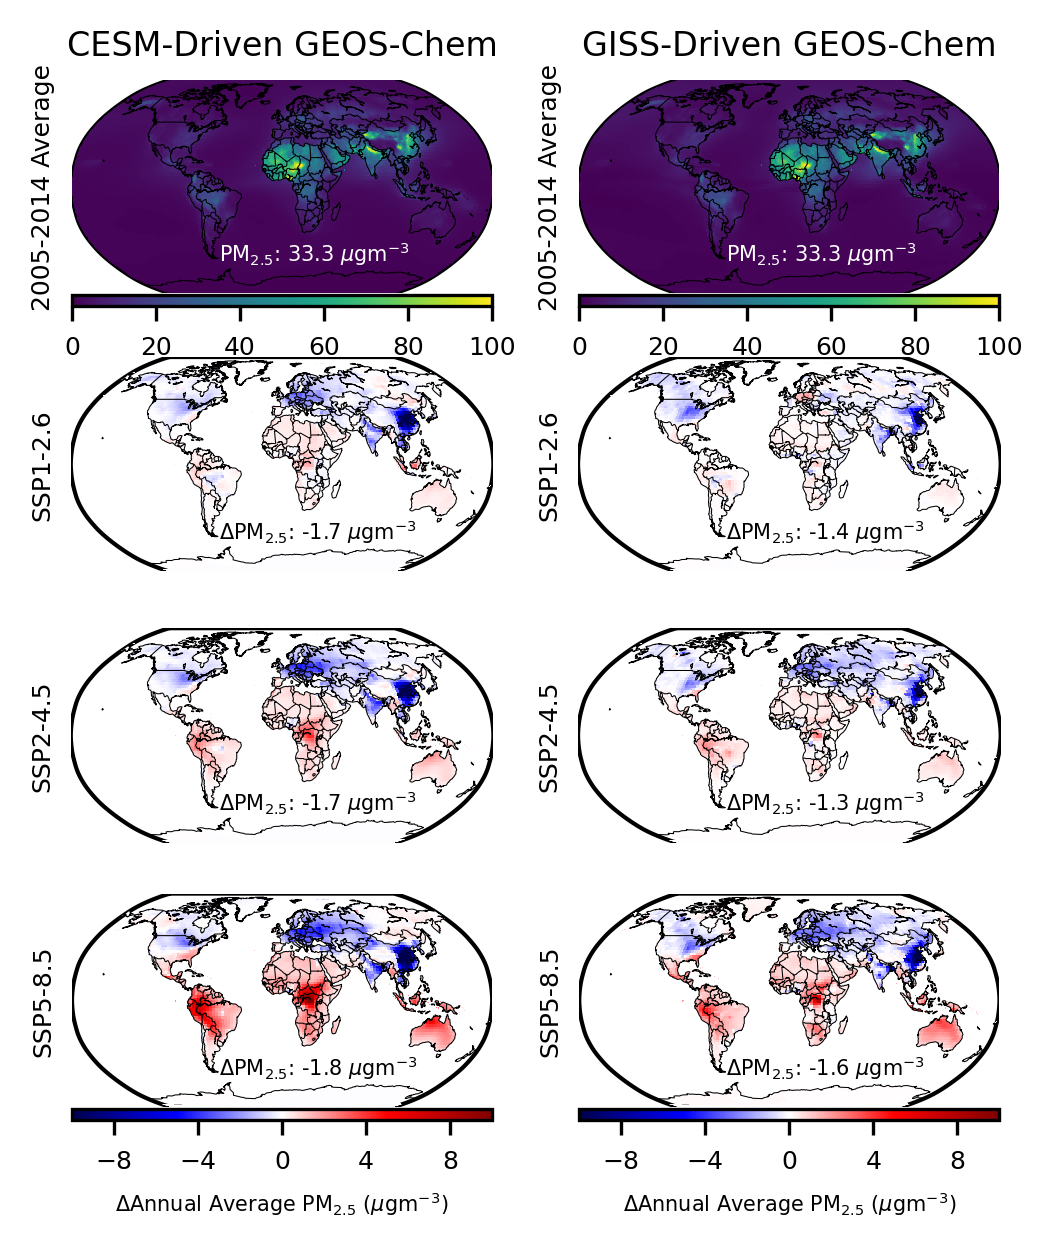

In [443]:
path_iec = 'C:/Users/EMCDUF01/Industrial Economics, Inc/IEc EPA CSIB Share - IEc EPA CSIB Share/03_Global_AQ_Study/Data'

#replace with GISS data when avaialble
# make a plot of PM2.5 data (base in absolute and then delta for other 3 sims)
list_of_files = ['/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.base.nc', '/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.base.nc',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.clim126.2090s.nc','/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim126.2090s.nc',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.clim245.2090s.nc','/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim245.2090s.nc',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.clim585.2090s.nc','/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim585.2090s.nc']

data = Dataset(path_iec+list_of_files[0])
base_PM_cesm = data.variables['PM25'][0,0,:,:]
data = Dataset(path_iec+list_of_files[1])
base_PM_giss = data.variables['PM25'][0,0,:,:]
#base_PM = base_PM+DSSC
DSSC_filled = DSSC.filled(0) #convert the masked array to a numerical array

numplts=8
fig = plt.figure(dpi=300,figsize=(4,4.5))

for iplt in np.arange(0,numplts):
    ax = fig.add_subplot(4,2,iplt+1)
    
    data = Dataset(path_iec+list_of_files[iplt])
    lat = data.variables['lat'][:]
    lon = data.variables['lon'][:]
    PM = data.variables['PM25'][0,0,:,:]
    if ((iplt == 0)):
        PM=base_PM_cesm+np.transpose(DSSC_filled)
        #print(np.shape(base_PM_cesm))
        #print(np.shape(DSSC_filled))
    elif (iplt ==1):
        PM=base_PM_giss+np.transpose(DSSC_filled)
    elif iplt % 2 == 0:
        PM = (PM+np.transpose(DSSC_filled))-(base_PM_cesm+np.transpose(DSSC_filled))
        #print(np.shape(base_PM_cesm))
        #print(np.shape(DSSC_filled))
        #print(np.shape(PM))
    else:
        PM = (PM+np.transpose(DSSC_filled))-(base_PM_giss+np.transpose(DSSC_filled))
    PM=PM.transpose()
    

    #print(ozone)
    m = Basemap(projection='robin',lon_0=0,resolution='c')
    m.drawmapboundary(fill_color='White')
    m.drawcoastlines(linewidth=0.25,zorder=3)
    #m.drawstates(linewidth=0.25,zorder=3)
    m.drawcountries(linewidth=0.25,zorder=3)
    xpi,ypi = m(xp,yp)

    if ((iplt == 0) or (iplt ==1)):
        plot = m.pcolor(xpi,ypi,PM, vmin=0, vmax=100, snap=True,zorder=2)
    else:
        #print(np.shape(landmask2d))
        #landmaskt = np.transpose(landmask2d)
        data = np.ma.array(PM,mask =~landmask2d)
        #print(np.shape(data))
        plot = m.pcolor(xpi,ypi,data, vmin=-12, vmax=12, snap=True,zorder=2, cmap = 'seismic')
        
    if ((iplt ==0) or (iplt ==1)):
        cb = m.colorbar(plot, location = "bottom", pad = "1%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.set_xlabel('Annual Average PM$_{2.5}$ ($\\mu$gm$^{-3}$)',fontsize=5)
    elif ((iplt ==6) or (iplt ==7)):
        cb = m.colorbar(plot, location = "bottom", pad = "1%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.set_xlabel('$\Delta$Annual Average PM$_{2.5}$ ($\\mu$gm$^{-3}$)',fontsize=5)
        
    if ((iplt == 0) or (iplt ==1)):
        plt.ylabel('2005-2014 Average',fontsize=6)
    elif iplt % 2 == 0:
        plt.ylabel('SSP'+list_of_files[iplt][54]+'-'+list_of_files[iplt][55]+'.'+list_of_files[iplt][56],fontsize=6)
    else:
        plt.ylabel('SSP'+list_of_files[iplt][44]+'-'+list_of_files[iplt][45]+'.'+list_of_files[iplt][46],fontsize=6)

    if ((iplt ==0)):
        ax.set_title('CESM-Driven GEOS-Chem',fontsize=8)
    elif iplt ==1:
        ax.set_title('GISS-Driven GEOS-Chem',fontsize=8)

    cb.ax.tick_params(labelsize=6)
    
    data = PM
    #print(round(np.mean(np.mean(data)),1))
    if ((iplt ==0) or (iplt==1)):
        #data = PM
        data_df = netcdf_to_points(path_iec+list_of_files[iplt],'PM25')
        data_df['PM25'] = data_df.loc[:,'PM25']+basePM_df.loc[:,'DST_SSA']
        full_data_join = pd.merge(full_grid_join,data_df,how='left', on=['Lat','Lon'])
        full_data_join['PW_PM25'] = np.sum((full_data_join.loc[:,'total_pop']*full_data_join.loc[:,'PM25']))/full_data_join.loc[:,'World_Pop']
        strtext = 'PM$_{2.5}$: '+ str(round(np.nanmean(np.nanmean(full_data_join['PW_PM25'])),1))+ ' $\\mu$gm$^{-3}$'
        ax.annotate(strtext, xy=(0.30, 0.15), xycoords='axes fraction', 
               xytext=(0.35, 0.15), textcoords='axes fraction', color='white',fontsize=5)
    elif iplt % 2 == 0:
        data_df = netcdf_to_points(path_iec+list_of_files[iplt],'PM25')
        base_df = netcdf_to_points(path_iec+list_of_files[0],'PM25')
        data_df['Delta_PM25'] = data_df.loc[:,'PM25']- base_df.loc[:,'PM25']
        #print(delta_df)
        full_data_join = pd.merge(full_grid_join,data_df,how='left', on=['Lat','Lon'])
        full_data_join['PW_PM25'] = np.sum((full_data_join.loc[:,'total_pop']*full_data_join.loc[:,'Delta_PM25']))/full_data_join.loc[:,'World_Pop']
        #data = np.ma.array(PM,mask =~landmask2d)
        strtext = '$\Delta$PM$_{2.5}$: '+ str(round(np.nanmean(np.mean(full_data_join['PW_PM25'])),1))+ ' $\\mu$gm$^{-3}$'
        ax.annotate(strtext, xy=(0.3, 0.15), xycoords='axes fraction', 
               xytext=(0.35, 0.15), textcoords='axes fraction', color='black',fontsize=5)
    else:
        data_df = netcdf_to_points(path_iec+list_of_files[iplt],'PM25')
        base_df = netcdf_to_points(path_iec+list_of_files[1],'PM25')
        data_df['Delta_PM25'] = data_df.loc[:,'PM25']- base_df.loc[:,'PM25']
        #print(delta_df)
        full_data_join = pd.merge(full_grid_join,data_df,how='left', on=['Lat','Lon'])
        full_data_join['PW_PM25'] = np.sum((full_data_join.loc[:,'total_pop']*full_data_join.loc[:,'Delta_PM25']))/full_data_join.loc[:,'World_Pop']
        #data = np.ma.array(PM,mask =~landmask2d)
        strtext = '$\Delta$PM$_{2.5}$: '+ str(round(np.nanmean(np.mean(full_data_join['PW_PM25'])),1))+ ' $\\mu$gm$^{-3}$'
        ax.annotate(strtext, xy=(0.3, 0.15), xycoords='axes fraction', 
               xytext=(0.35, 0.15), textcoords='axes fraction', color='black',fontsize=5)
    #print(strtext)
    
    
#ax = plt.axes(projection=ccrs.Robinson())
#ax.contourf(lon,lat,ozone,cmap = 'seismic')

#ax = plt.axes(projection=ccrs.Robinson())
#ax.coastlines()
#ax1.gridlines(draw_labels=True)
plt.savefig('plot_PM25_supplemental.png', bbox_inches='tight')
plt.show();

#print(ozone)
#print(lat)

C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\556243056.py:59: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,np.transpose(data), vmin=-22, vmax=22, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\556243056.py:68: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\556243056.py:59: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated c

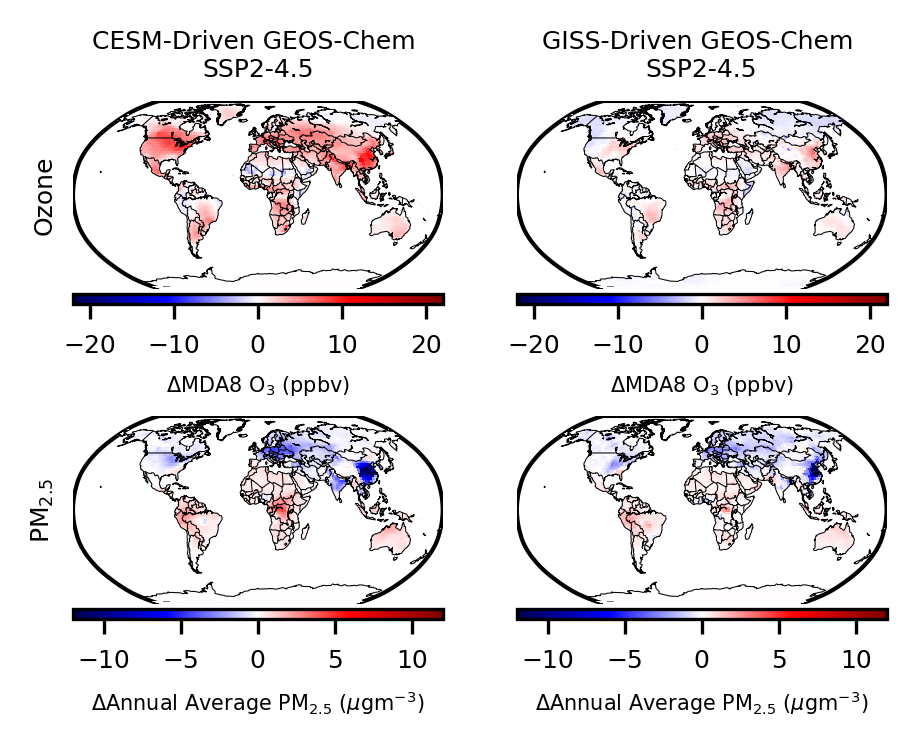

In [457]:
# make main text plot
# 4 panels with SSP245 results (Delta's)
#a) CESM-ozone
#b) GISS ozone
#c) CESM PM
#d) GISS PM

path_iec = 'C:/Users/EMCDUF01/Industrial Economics, Inc/IEc EPA CSIB Share - IEc EPA CSIB Share/03_Global_AQ_Study/Data'
list_of_files = ['/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.base.nc', '/GCAP2-GISS_Raw Data/Ozone/OSDMA8.base.nc4',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.base.nc', '/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.base.nc',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim245.2090s.nc','/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim245.2090s.nc4',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/PM25.noDSTnoSSA.clim245.2090s.nc','/GCAP2-GISS_Raw Data/PM/PM25.noDSTnoSSA.clim245.2090s.nc']

data = Dataset(path_iec+list_of_files[0])
base_ozone_cesm = data.variables['MDA8'][0,0,:,:]
data = Dataset(path_iec+list_of_files[1])
base_ozone_giss = data.variables['corrected'][:,:]
data = Dataset(path_iec+list_of_files[2])
base_PM_cesm = data.variables['PM25'][0,0,:,:]
data = Dataset(path_iec+list_of_files[3])
base_PM_giss = data.variables['PM25'][0,0,:,:]

numplts=4
fig = plt.figure(dpi=300,figsize=(3.5,2.5))

for iplt in np.arange(0,numplts):
    ax = fig.add_subplot(2,2,iplt+1)
    ifile = iplt+4
    data = Dataset(path_iec+list_of_files[ifile])
    lat = data.variables['lat'][:]
    lon = data.variables['lon'][:]
    if ((iplt == 0)):
        delta_data = data.variables['MDA8'][0,0,:,:] - base_ozone_cesm
    elif iplt ==1:
        delta_data = data.variables['corrected'][:,:] - base_ozone_giss
    elif (iplt == 2):
        delta_data = data.variables['PM25'][0,0,:,:] - base_PM_cesm
    elif (iplt ==3):
        delta_data = data.variables['PM25'][0,0,:,:] - base_PM_giss
    #print(np.shape(delta_data))
    
    #print(ozone)
    m = Basemap(projection='robin',lon_0=0,resolution='c')
    m.drawmapboundary(fill_color='White')
    m.drawcoastlines(linewidth=0.25,zorder=3)
    m.drawcountries(linewidth=0.25,zorder=3)
    xpi,ypi = m(xp,yp)

    #if ((iplt == 0) or (iplt ==1)):
    #    plot = m.pcolor(xpi,ypi,PM, vmin=0, vmax=100, snap=True,zorder=2)
    #else:
        #print(np.shape(landmask2d))
    landmaskt = np.transpose(landmask2d)
    #print(np.shape(landmaskt))
    data = np.ma.array(delta_data,mask =~landmaskt)
    #print(np.shape(data))
    #print(np.shape(data))
    if ((iplt == 0) or (iplt ==1)):
        plot = m.pcolor(xpi,ypi,np.transpose(data), vmin=-22, vmax=22, snap=True,zorder=2, cmap = 'seismic')
    else:
        plot = m.pcolor(xpi,ypi,np.transpose(data), vmin=-12, vmax=12, snap=True,zorder=2, cmap = 'seismic')

    if ((iplt ==0)):
        ax.set_title('CESM-Driven GEOS-Chem \nSSP2-4.5',fontsize=6)
    elif iplt ==1:
        ax.set_title('GISS-Driven GEOS-Chem \nSSP2-4.5',fontsize=6)
        
    cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    if  ((iplt ==0) or (iplt ==1)):
        cb.ax.set_xlabel('$\Delta$MDA8 O$_{3}$ (ppbv)',fontsize=5)
    elif ((iplt ==2) or (iplt ==3)):
        cb.ax.set_xlabel('$\Delta$Annual Average PM$_{2.5}$ ($\\mu$gm$^{-3}$)',fontsize=5)
        
    if iplt ==0:
        plt.ylabel('Ozone',fontsize=6)
    elif iplt ==2:
        plt.ylabel('PM$_{2.5}$',fontsize=6)
    cb.ax.tick_params(labelsize=6)

plt.savefig('Figure2_delta_concentrations.png', bbox_inches='tight')
plt.show();

# Plot Met Data Results

C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:99: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,data, vmin=0, vmax=100, snap=True,zorder=2)


(720, 360) (360, 720)
Average change Ozone:  -0.27260338694339753


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:106: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,np.transpose(data), vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


(720, 360) (360, 720)
Average change Ozone:  0.009875157148771926


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:106: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,np.transpose(data), vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


(720, 360) (360, 720)
Average change Ozone:  1.0623675015703518


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:106: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,np.transpose(data), vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:115: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculate

Average change Temp:  0.279014874969099


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:127: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Temp:  0.6736725975380992


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:127: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Temp:  1.5249791418246859


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:127: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:136: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edge

Average change H2O:  6.503621779025128


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:149: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change H2O:  14.70176262942066


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:149: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change H2O:  32.48989719055375


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:149: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:159: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell ed

Average change PBLH:  0.743854904352315


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:171: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change PBLH:  1.8212590703524896


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:171: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change PBLH:  6.324162401116799


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:171: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:180: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell ed

Average change Precip:  1.8632809091801419


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:192: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Precip:  5.35431178018846


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:192: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Precip:  9.939570367031177


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:192: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:201: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell ed

Average change Wind:  -8.147074220567706


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:213: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Wind:  -8.400515137854816


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:213: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Wind:  -32.6364006514658


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:213: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:223: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell ed

55.11621 49.427734 49.59143
Average change Theta:  3.1829548263727316


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:236: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


53.599213 50.588226 49.59143
Average change Theta:  4.269329484644021


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:236: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


53.97705 53.470184 49.59143
Average change Theta:  5.928019754827827


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:236: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\993650399.py:269: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


ValueError: num must be an integer with 1 <= num <= 28, not 29

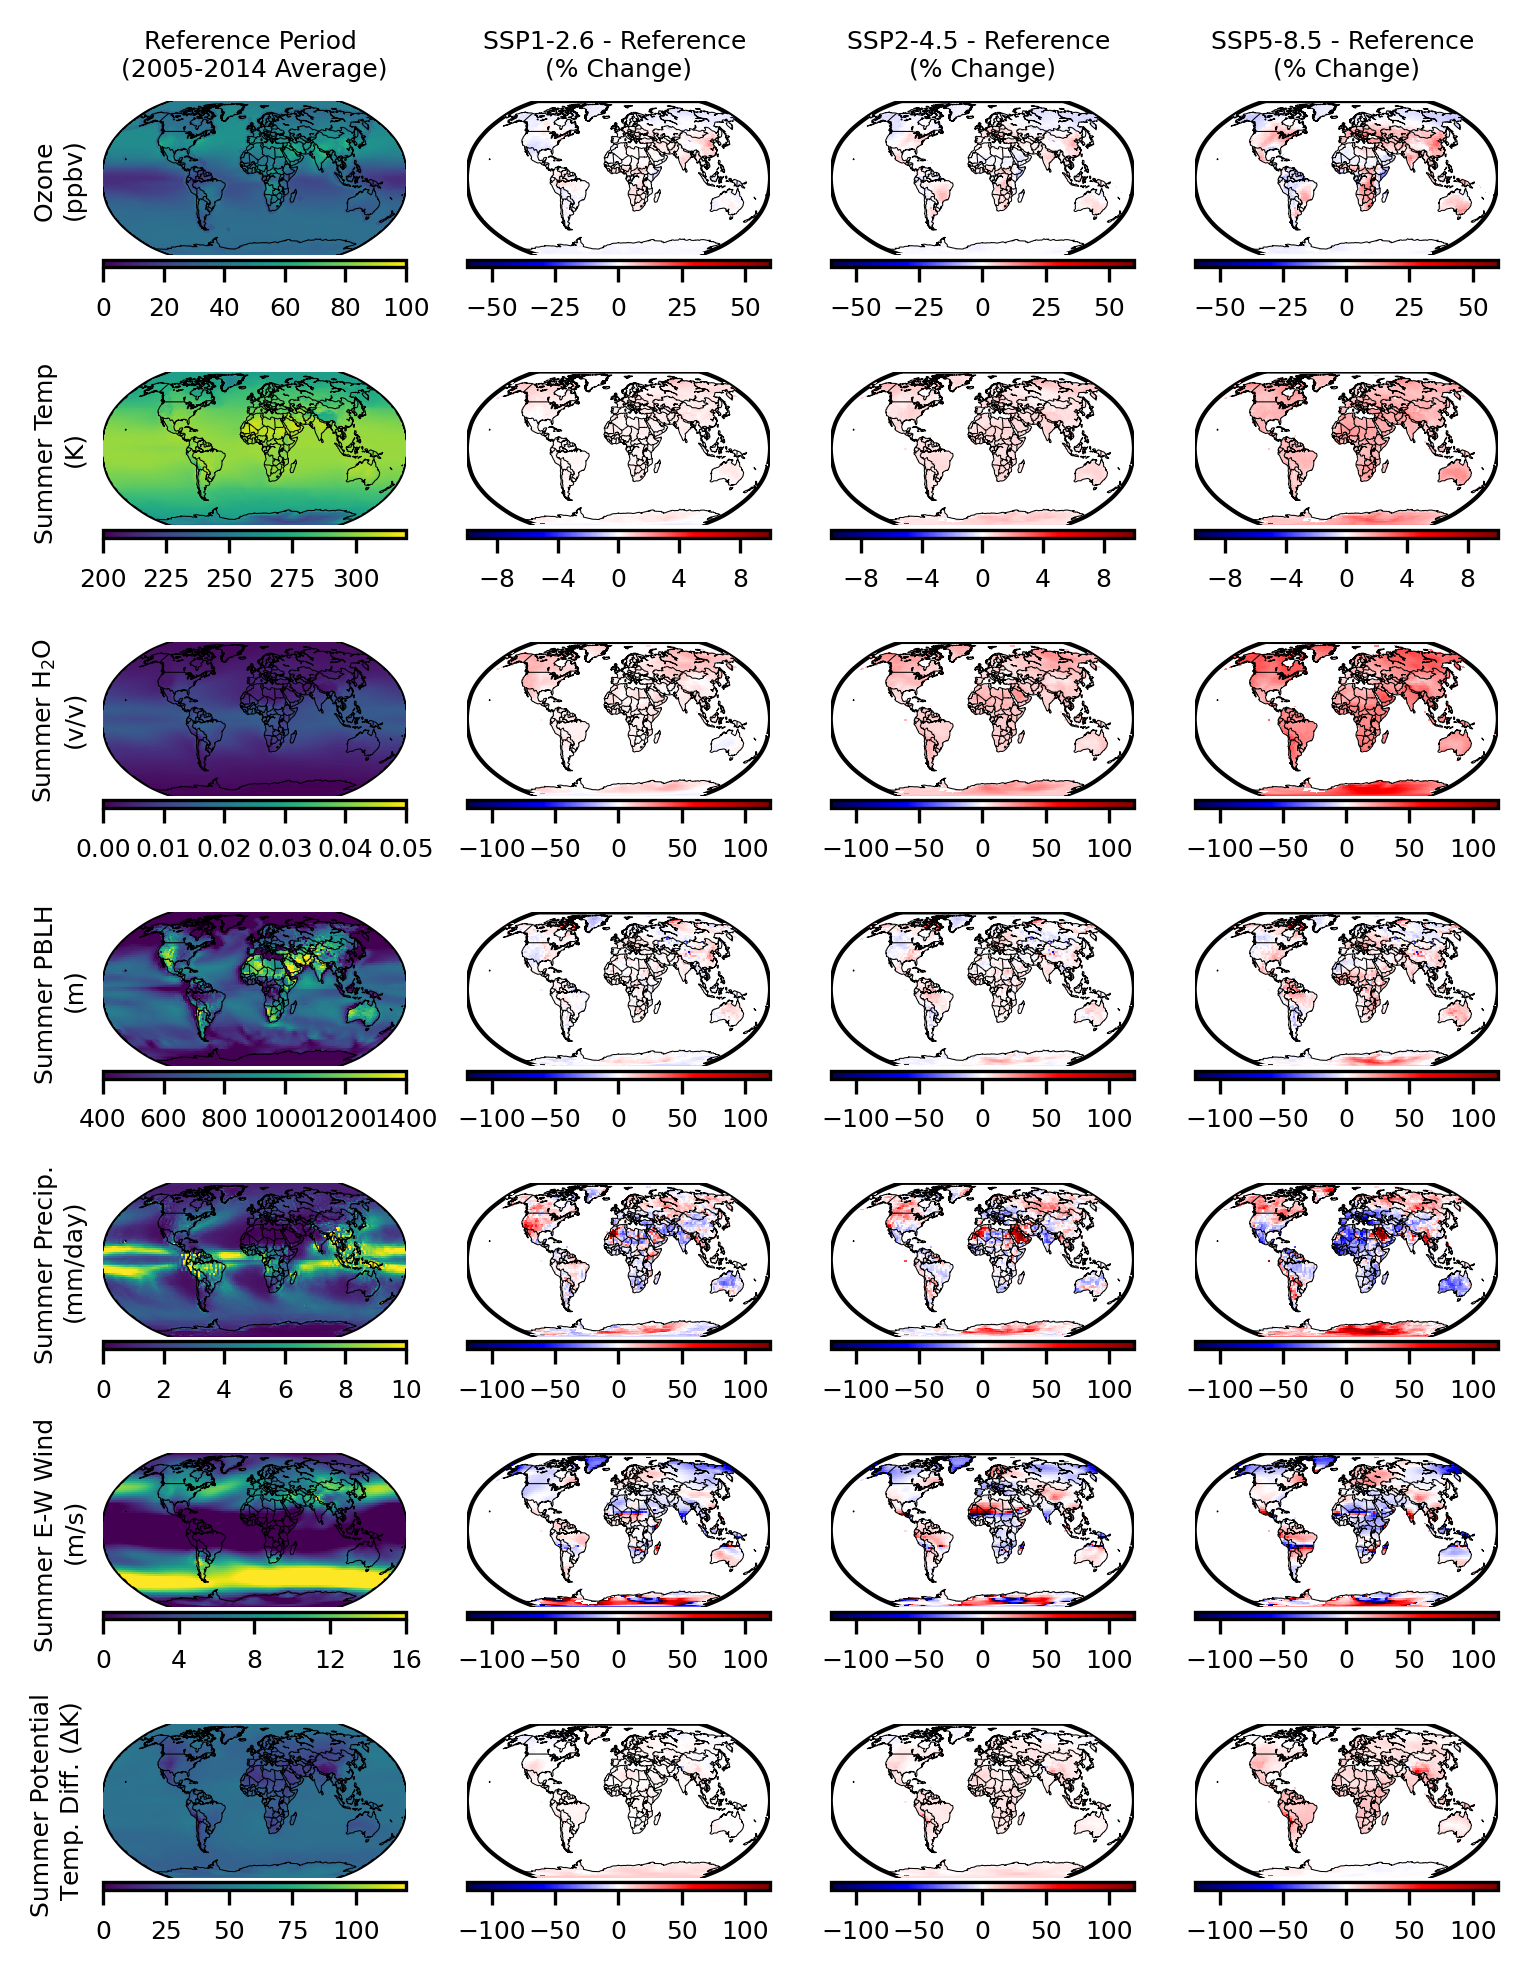

In [739]:
# Plot Ozone results

#SSP126, 245, 585 vs ozone, temp, pblh, precip, dry dep, biogenics, E-W wind

#1 Read in Met data files
# calculate the delta relative to the base for each month?
# 2 Take summertime annual average of the deltas for NH and SH, then stick back together
# 3) then plot the resulting deltas and show compared to ozone results? (need to use 0.5x0.5 meshgrid, as well as a 2x2.5 meshgrid). 

#GISS ozone plots
path_iec = 'C:/Users/EMCDUF01/Industrial Economics, Inc/IEc EPA CSIB Share - IEc EPA CSIB Share/03_Global_AQ_Study/Data'
list_of_files = ['/GCAP2-GISS_Raw Data/Ozone/OSDMA8.base.nc4', 
                '/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim126.2090s.nc4','/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim245.2090s.nc4',
                 '/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim585.2090s.nc4',
                 '/GCAP2-GISS_Raw Data/GEOSChem.E21.StateMet.base.ymonmean.nc4',
                 '/GCAP2-GISS_Raw Data/GEOSChem.E21.StateMet.clim126.2090s.ymonmean.nc4',
                 '/GCAP2-GISS_Raw Data/GEOSChem.E21.StateMet.clim245.2090s.ymonmean.nc4',
                '/GCAP2-GISS_Raw Data/GEOSChem.E21.StateMet.clim585.2090s.ymonmean.nc4',]

data = Dataset(path_iec+list_of_files[0])
#base_ozone_cesm = data.variables['MDA8'][0,0,:,:]
#data = Dataset(path_iec+list_of_files[1])
base_ozone_giss = data.variables['corrected'][:,:]

data = Dataset(path_iec+list_of_files[4])
#print(data)
#print(np.shape(latarray))

TS = data.variables['Met_TS']
TS_NH = np.ma.getdata(np.transpose(np.mean(TS[3:8,:,:], axis = 0)))
TS_SH = np.ma.getdata(np.transpose(np.mean(TS[[0,1,2,9,10,11],:,:], axis = 0)))
TS_NH = np.where((latarray >= 0), TS_NH, 0)
TS_SH = np.where((latarray < 0), TS_SH, 0)
TS_summer_base = TS_NH + TS_SH

TropLevel = data.variables['Met_TropLev'] #global average trop level is 23 (can make more specific mask later)
Wind = data.variables['Met_U']
#print(np.shape(Wind))
Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[3:8,0:20,:,:], axis = (0,1))))
Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
Wind_SH = np.where((latarray < 0), Wind_SH, 0)
Wind_summer_base = Wind_NH + Wind_SH

PBLH = data.variables['Met_PBLH']
PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[3:8,:,:], axis = 0)))
PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[[0,1,2,9,10,11],:,:], axis = 0)))
PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
PBLH_summer_base = PBLH_NH + PBLH_SH

Precip = data.variables['Met_PRECTOT']
Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[3:8,:,:], axis = 0)))
Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[[0,1,2,9,10,11],:,:], axis = 0)))
Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
Precip_SH = np.where((latarray < 0), Precip_SH, 0)
Precip_summer_base = Precip_NH + Precip_SH

H2O = data.variables['Met_AVGW']
H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[3:8,0:20,:,:], axis = (0,1))))
H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
H2O_SH = np.where((latarray < 0), H2O_SH, 0)
H2O_summer_base = H2O_NH + H2O_SH

#Incident shortwave radiation at ground (W/m2)
SW = data.variables['Met_SWGDN']
SW_NH = np.ma.getdata(np.transpose(np.mean(SW[3:8,:,:], axis = 0)))
SW_SH = np.ma.getdata(np.transpose(np.mean(SW[[0,1,2,9,10,11],:,:], axis = 0)))
SW_NH = np.where((latarray >= 0), SW_NH, 0)
SW_SH = np.where((latarray < 0), SW_SH, 0)
SW_summer_base = SW_NH + SW_SH

Theta = data.variables['Met_THETA']
Theta_NH = np.ma.getdata(np.transpose(np.mean(Theta[3:8,17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(Theta[3:8,0,:,:], axis = 0)))
Theta_SH = np.ma.getdata(np.transpose(np.mean(Theta[[0,1,2,9,10,11],17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(Theta[[0,1,2,9,10,11],0,:,:], axis = 0)))
Theta_NH = np.where((latarray >= 0), Theta_NH, 0)
Theta_SH = np.where((latarray < 0), Theta_SH, 0)
Theta_summer_base = Theta_NH + Theta_SH

numplts=32
fig = plt.figure(dpi=300,figsize=(6,8))

for iplt in np.arange(0,numplts):
    ax = fig.add_subplot(7,4,iplt+1)
    m = Basemap(projection='robin',lon_0=0,resolution='c')
    m.drawmapboundary(fill_color='White')
    m.drawcoastlines(linewidth=0.25,zorder=3)
    m.drawcountries(linewidth=0.25,zorder=3)
    xpi25,ypi2 = m(xp25,yp2)
    xpi,ypi = m(xp,yp)

    #data = Dataset(path_iec+list_of_files[iplt])

    if ((iplt == 0)):
        data = np.transpose(base_ozone_giss)
        #print(np.shape(base_ozone_giss))
        #print(np.shape(xpi))
        plot = m.pcolor(xpi,ypi,data, vmin=0, vmax=100, snap=True,zorder=2)
    elif ((iplt == 1) or (iplt == 2) or (iplt == 3)):
        data = Dataset(path_iec+list_of_files[iplt])
        data = 100*(data.variables['corrected'][:,:] - base_ozone_giss)/base_ozone_giss
        print(np.shape(landmask2d), np.shape(data))
        data = np.ma.array(data,mask =~np.transpose(landmask2d))
        print('Average change Ozone: ',+np.mean(data))
        plot = m.pcolor(xpi,ypi,np.transpose(data), vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
    elif ((iplt ==4)):
        data = Dataset(path_iec+list_of_files[iplt])
        TS = data.variables['Met_TS']
        TS_NH = np.ma.getdata(np.transpose(np.mean(TS[3:8,:,:], axis = 0)))
        TS_SH = np.ma.getdata(np.transpose(np.mean(TS[[0,1,2,9,10,11],:,:], axis = 0)))
        TS_NH = np.where((latarray >= 0), TS_NH, 0)
        TS_SH = np.where((latarray < 0), TS_SH, 0)
        TS_summer = TS_NH + TS_SH
        plot = m.pcolor(xpi25,ypi2,TS_summer, vmin=200, vmax=320, snap=True,zorder=2)
    elif ((iplt >= 5) and (iplt <8)):
        data = Dataset(path_iec+list_of_files[iplt])
        TS = data.variables['Met_TS']
        TS_NH = np.ma.getdata(np.transpose(np.mean(TS[3:8,:,:], axis = 0)))
        TS_SH = np.ma.getdata(np.transpose(np.mean(TS[[0,1,2,9,10,11],:,:], axis = 0)))
        TS_NH = np.where((latarray >= 0), TS_NH, 0)
        TS_SH = np.where((latarray < 0), TS_SH, 0)
        TS_summer = TS_NH + TS_SH
        TS_summer = 100*(TS_summer - TS_summer_base)/TS_summer_base
        data = np.ma.array(TS_summer,mask =~landmask2x25)
        print('Average change Temp: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')
    elif ((iplt ==8)):
        data = Dataset(path_iec+list_of_files[iplt-4])
        H2O = data.variables['Met_AVGW']
        H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[3:8,0:20,:,:], axis = (0,1))))
        H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
        H2O_SH = np.where((latarray < 0), H2O_SH, 0)
        H2O_summer = H2O_NH + H2O_SH
        plot = m.pcolor(xpi25,ypi2,H2O_summer, vmin=0, vmax=0.05, snap=True,zorder=2)
        
    elif ((iplt >= 9) and (iplt < 12)):
        data = Dataset(path_iec+list_of_files[iplt-4])
        H2O = data.variables['Met_AVGW']
        H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[3:8,0:20,:,:], axis = (0,1))))
        H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
        H2O_SH = np.where((latarray < 0), H2O_SH, 0)
        H2O_summer = H2O_NH + H2O_SH
        H2O_summer = 100*(H2O_summer - H2O_summer_base)/H2O_summer_base
        data = np.ma.array(H2O_summer,mask =~landmask2x25)
        print('Average change H2O: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
        
    elif ((iplt ==12)):
        data = Dataset(path_iec+list_of_files[iplt-8])
        PBLH = data.variables['Met_PBLH']
        PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[3:8,:,:], axis = 0)))
        PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[[0,1,2,9,10,11],:,:], axis = 0)))
        PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
        PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
        PBLH_summer = PBLH_NH + PBLH_SH
        plot = m.pcolor(xpi25,ypi2,PBLH_summer, vmin=400, vmax=1400, snap=True,zorder=2)
    elif ((iplt >= 13) and (iplt < 16)):
        data = Dataset(path_iec+list_of_files[iplt-8])
        PBLH = data.variables['Met_PBLH']
        PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[3:8,:,:], axis = 0)))
        PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[[0,1,2,9,10,11],:,:], axis = 0)))
        PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
        PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
        PBLH_summer = PBLH_NH + PBLH_SH
        PBLH_summer = 100*(PBLH_summer - PBLH_summer_base)/PBLH_summer_base
        data = np.ma.array(PBLH_summer,mask =~landmask2x25)
        print('Average change PBLH: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
    elif (iplt ==16):
        data = Dataset(path_iec+list_of_files[iplt-12])
        Precip = data.variables['Met_PRECTOT']
        Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[3:8,:,:], axis = 0)))
        Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[[0,1,2,9,10,11],:,:], axis = 0)))
        Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
        Precip_SH = np.where((latarray < 0), Precip_SH, 0)
        Precip_summer = Precip_NH + Precip_SH
        plot = m.pcolor(xpi25,ypi2,Precip_summer, vmin=0, vmax=10, snap=True,zorder=2)
    elif ((iplt >= 17) and (iplt < 20)):
        data = Dataset(path_iec+list_of_files[iplt-12])
        Precip = data.variables['Met_PRECTOT']
        Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[3:8,:,:], axis = 0)))
        Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[[0,1,2,9,10,11],:,:], axis = 0)))
        Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
        Precip_SH = np.where((latarray < 0), Precip_SH, 0)
        Precip_summer = Precip_NH + Precip_SH
        Precip_summer = 100*(Precip_summer - Precip_summer_base)/Precip_summer_base
        data = np.ma.array(Precip_summer,mask =~landmask2x25)
        print('Average change Precip: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
    elif (iplt ==20):
        data = Dataset(path_iec+list_of_files[iplt-16])
        Wind = data.variables['Met_U']
        Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[3:8,0:20,:,:], axis = (0,1))))
        Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
        Wind_SH = np.where((latarray < 0), Wind_SH, 0)
        Wind_summer = Wind_NH + Wind_SH
        plot = m.pcolor(xpi25,ypi2,Wind_summer_base, vmin=0, vmax=16, snap=True,zorder=2)
    elif ((iplt >= 21) and (iplt < 24)):
        data = Dataset(path_iec+list_of_files[iplt-16])
        Wind = data.variables['Met_U']
        Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[3:8,0:20,:,:], axis = (0,1))))
        Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
        Wind_SH = np.where((latarray < 0), Wind_SH, 0)
        Wind_summer = Wind_NH + Wind_SH
        Wind_summer = 100*(Wind_summer - Wind_summer_base)/Wind_summer_base
        data = np.ma.array(Wind_summer,mask =~landmask2x25)
        print('Average change Wind: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
    elif (iplt==24):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-20])
        theta = data.variables['Met_THETA']
        theta_NH = np.ma.getdata(np.transpose(np.mean(Theta[3:8,17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(Theta[3:8,0,:,:], axis = 0)))
        theta_SH = np.ma.getdata(np.transpose(np.mean(Theta[[0,1,2,9,10,11],17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(Theta[[0,1,2,9,10,11],0,:,:], axis = 0)))
        theta_NH = np.where((latarray >= 0), theta_NH, 0)
        theta_SH = np.where((latarray < 0), theta_SH, 0)
        theta_summer = theta_NH + theta_SH
        plot = m.pcolor(xpi25,ypi2,theta_summer, vmin=0, vmax=120, snap=True,zorder=2)
    elif ((iplt >= 25) and (iplt < 28)):
        data = Dataset(path_iec+list_of_files[iplt-20])
        theta = data.variables['Met_THETA']
        theta_NH = np.ma.getdata(np.transpose(np.mean(theta[3:8,17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(theta[3:8,0,:,:], axis = 0)))
        theta_SH = np.ma.getdata(np.transpose(np.mean(theta[[0,1,2,9,10,11],17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(theta[[0,1,2,9,10,11],0,:,:], axis = 0)))
        theta_NH = np.where((latarray >= 0), theta_NH, 0)
        theta_SH = np.where((latarray < 0), theta_SH, 0)
        print(np.max(theta_SH), np.max(theta_NH), np.max(Theta_summer_base))
        theta_summer = theta_NH + theta_SH
        theta_summer = 100*(theta_summer - Theta_summer_base)/Theta_summer_base
        data = np.ma.array(theta_summer,mask =~landmask2x25)
        print('Average change Theta: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
    elif (iplt==28):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-24])
        SW = data.variables['Met_SWGND']
        SW_NH = np.ma.getdata(np.transpose(np.mean(SW[3:8,:,:], axis = 0)))
        SW_SH = np.ma.getdata(np.transpose(np.mean(SW[[0,1,2,9,10,11],:,:], axis = 0)))
        SW_NH = np.where((latarray >= 0), SW_NH, 0)
        SW_SH = np.where((latarray < 0), SW_SH, 0)
        SW_summer = SW_NH + SW_SH
        plot = m.pcolor(xpi25,ypi2,SW_summer, vmin=0, vmax=120, snap=True,zorder=2)
    elif ((iplt >= 29) and (iplt < 32)):
        data = Dataset(path_iec+list_of_files[iplt-24])
        SW = data.variables['Met_SWGND']
        SW_NH = np.ma.getdata(np.transpose(np.mean(SW[3:8,:,:], axis = 0)))
        SW_SH = np.ma.getdata(np.transpose(np.mean(SW[[0,1,2,9,10,11],:,:], axis = 0)))
        SW_NH = np.where((latarray >= 0), SW_NH, 0)
        SW_SH = np.where((latarray < 0), SW_SH, 0)
        SW_summer = SW_NH + SW_SH
        SW_summer = 100*(SW_summer - SW_summer_base)/SW_summer_base
        data = np.ma.array(SW_summer,mask =~landmask2x25)
        print('Average change SW at Ground: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')

    if ((iplt ==0)):
        ax.set_title('Reference Period \n(2005-2014 Average)',fontsize=6)
    elif iplt ==1:
        ax.set_title('SSP1-2.6 - Reference \n(% Change)',fontsize=6)
    elif iplt ==2:
        ax.set_title('SSP2-4.5 - Reference \n(% Change)',fontsize=6)
    elif iplt ==3:
        ax.set_title('SSP5-8.5 - Reference \n(% Change)',fontsize=6)

    cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    #if  ((iplt ==0) or (iplt ==1)):
    #    cb.ax.set_xlabel('$\Delta$MDA8 O$_{3}$ (ppbv)',fontsize=5)
    #elif ((iplt ==2) or (iplt ==3)):
    #    cb.ax.set_xlabel('$\Delta$Annual Average PM$_{2.5}$ ($\\mu$gm$^{-3}$)',fontsize=5)
    cb.ax.tick_params(labelsize=6)
    if iplt ==0:
        plt.ylabel('Ozone \n(ppbv)',fontsize=6)
    elif iplt ==4:
        plt.ylabel('Summer Temp \n(K)',fontsize=6)
    elif iplt ==8:
        plt.ylabel('Summer H$_2$O \n(v/v)',fontsize=6)
    elif iplt ==12:
        plt.ylabel('Summer PBLH \n(m)',fontsize=6)   
    elif iplt ==16:
        plt.ylabel('Summer Precip. \n(mm/day)',fontsize=6)
    elif iplt ==20:
        plt.ylabel('Summer E-W Wind \n(m/s)',fontsize=6)
    elif iplt ==24:
        plt.ylabel('Summer Potential \nTemp. Diff. ($\Delta$K)',fontsize=6)
    elif iplt ==28:
        plt.ylabel('Summer SW \nRadiation (W/m$^2$)',fontsize=6)

plt.savefig('FigureS4_summer_giss_ozone_maps.png', bbox_inches='tight')
plt.show();

C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2184239422.py:127: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=0, vmax=100, snap=True,zorder=2)


(144, 90) (144, 90)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2184239422.py:142: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2184239422.py:143: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


(144, 90) (144, 90)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2184239422.py:142: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2184239422.py:143: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


(144, 90) (144, 90)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2184239422.py:142: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2184239422.py:143: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2184239422.py:156: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell e

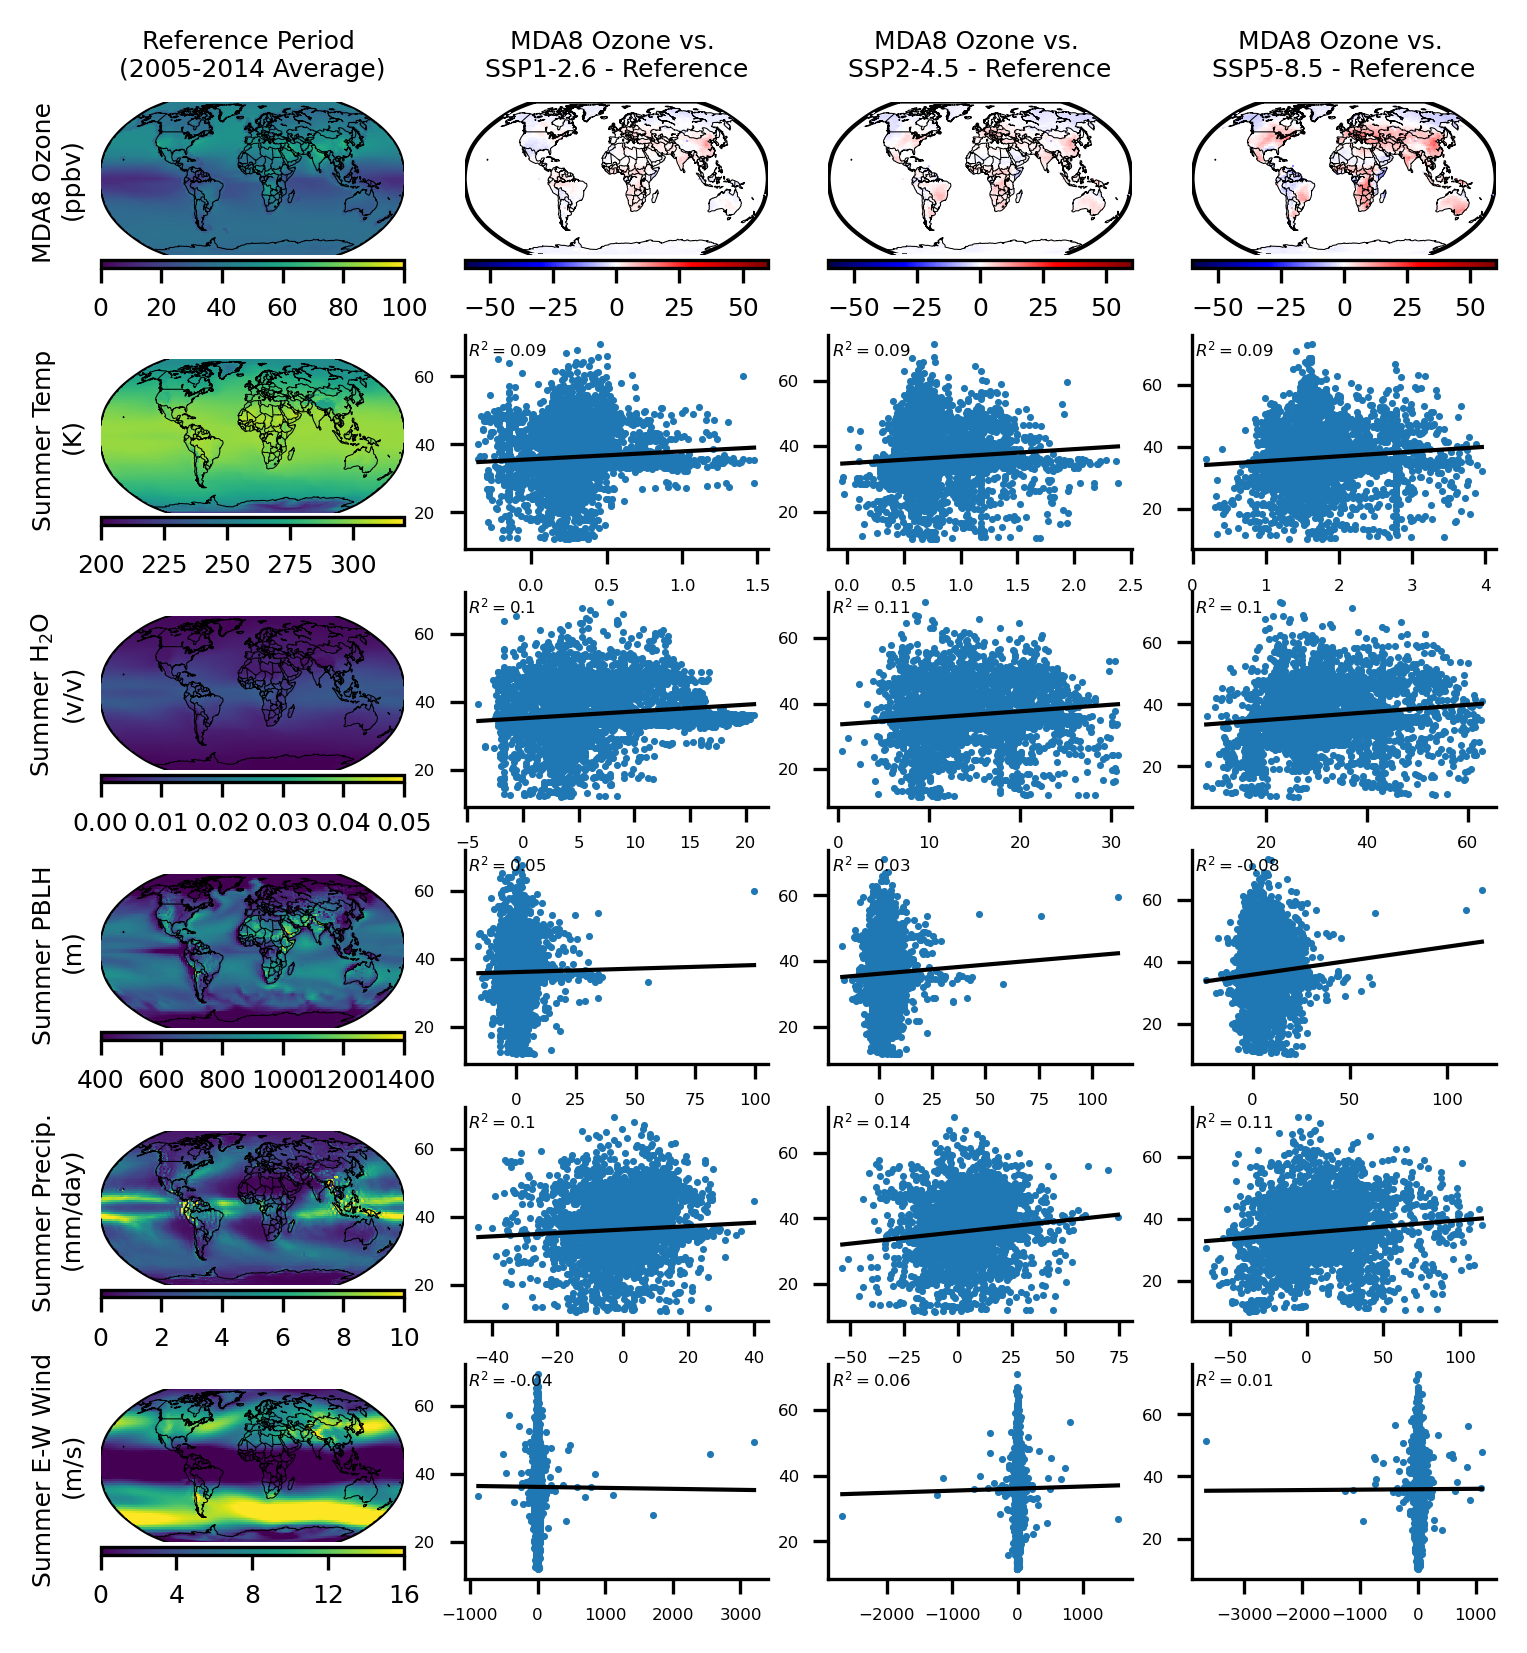

In [708]:
## GISS regression plots

# Plot Ozone results

#SSP126, 245, 585 vs ozone, temp, pblh, precip, dry dep, biogenics, E-W wind

#1 Read in Met data files
# calculate the delta relative to the base for each month?
# 2 Take summertime annual average of the deltas for NH and SH, then stick back together
# 3) then plot the resulting deltas and show compared to ozone results? (need to use 0.5x0.5 meshgrid, as well as a 2x2.5 meshgrid). 

#GISS ozone plots
path_iec = 'C:/Users/EMCDUF01/Industrial Economics, Inc/IEc EPA CSIB Share - IEc EPA CSIB Share/03_Global_AQ_Study/Data'
list_of_files = ['/GCAP2-GISS_Raw Data/Ozone/OSDMA8.base.nc4', 
                '/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim126.2090s.nc4','/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim245.2090s.nc4',
                 '/GCAP2-GISS_Raw Data/Ozone/OSDMA8.clim585.2090s.nc4',
                 '/GCAP2-GISS_Raw Data/GEOSChem.E21.StateMet.base.ymonmean.nc4',
                 '/GCAP2-GISS_Raw Data/GEOSChem.E21.StateMet.clim126.2090s.ymonmean.nc4',
                 '/GCAP2-GISS_Raw Data/GEOSChem.E21.StateMet.clim245.2090s.ymonmean.nc4',
                '/GCAP2-GISS_Raw Data/GEOSChem.E21.StateMet.clim585.2090s.ymonmean.nc4',]

#regionmask
#region_mask = usamask2x25
region_mask = landmask2x25
NH_summer = [3,4,5,6,7,8] #np.arange(0,11) #
SH_summer = [0,1,2,9,10,11] #np.arange(0,11) #

#re-grid the ozone data to the 2x2.5 resolution of the met data (alternatively could have regridded the met data...)
data_ozone = xr.open_dataset(path_iec+list_of_files[0])
data = Dataset(path_iec+list_of_files[4])
regrid_lat = data.variables['lat']
regrid_lon = data.variables['lon']
regridded_data = data_ozone.interp(lat=regrid_lat,lon=regrid_lon,method ='linear')
base_ozone_giss = regridded_data.variables['corrected'][:,:].transpose()
#print(np.shape(base_ozone_cesm))
data_ozone = xr.open_dataset(path_iec+list_of_files[1])
regridded_data = data_ozone.interp(lat=regrid_lat,lon=regrid_lon,method ='linear')
ssp126_ozone_giss = regridded_data.variables['corrected'][:,:].transpose()
data_ozone = xr.open_dataset(path_iec+list_of_files[2])
regridded_data = data_ozone.interp(lat=regrid_lat,lon=regrid_lon,method ='linear')
ssp245_ozone_giss = regridded_data.variables['corrected'][:,:].transpose()
data_ozone = xr.open_dataset(path_iec+list_of_files[3])
regridded_data = data_ozone.interp(lat=regrid_lat,lon=regrid_lon,method ='linear')
ssp585_ozone_giss = regridded_data.variables['corrected'][:,:].transpose()
#data = Dataset(path_iec+list_of_files[1])
#base_ozone_giss = data.variables['corrected'][:,:]

#these data are at 2x2.5 resolution (the resolution of the GCMs)
data = Dataset(path_iec+list_of_files[4])
#print(data.variables)
#print(np.shape(latarray))

TS = data.variables['Met_TS']
TS_NH = np.ma.getdata(np.transpose(np.mean(TS[NH_summer,:,:], axis = 0)))
TS_SH = np.ma.getdata(np.transpose(np.mean(TS[SH_summer,:,:], axis = 0)))
TS_NH = np.where((latarray >= 0), TS_NH, 0)
TS_SH = np.where((latarray < 0), TS_SH, 0)
TS_summer_base = TS_NH + TS_SH

TropLevel = data.variables['Met_TropLev'] #global average trop level is 23 (can make more specific mask later)
Wind = data.variables['Met_U']
#print(np.shape(Wind))
Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[NH_summer,0:20,:,:], axis = (0,1))))
Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[SH_summer,0:20,:,:], axis = (0,1))))
Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
Wind_SH = np.where((latarray < 0), Wind_SH, 0)
Wind_summer_base = Wind_NH + Wind_SH

PBLH = data.variables['Met_PBLH']
PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[NH_summer,:,:], axis = 0)))
PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[SH_summer,:,:], axis = 0)))
PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
PBLH_summer_base = PBLH_NH + PBLH_SH

Precip = data.variables['Met_PRECTOT']
Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[NH_summer,:,:], axis = 0)))
Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[SH_summer,:,:], axis = 0)))
Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
Precip_SH = np.where((latarray < 0), Precip_SH, 0)
Precip_summer_base = Precip_NH + Precip_SH

H2O = data.variables['Met_AVGW']
#print(np.shape(H2O))
H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[NH_summer,0:20,:,:], axis = (0,1))))
H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[SH_summer,0:20,:,:], axis = (0,1))))
H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
H2O_SH = np.where((latarray < 0), H2O_SH, 0)
H2O_summer_base = H2O_NH + H2O_SH

#data = Dataset(path_iec+list_of_files[8])
#drydep = data.variables['DryDepVel_O3']
#drydep_NH = np.ma.getdata(np.transpose(np.mean(drydep[3:8,:,:], axis = 0)))
#drydep_SH = np.ma.getdata(np.transpose(np.mean(drydep[[0,1,2,9,10,11],:,:], axis = 0)))
#drydep_NH = np.where((latarray >= 0), drydep_NH, 0)
#drydep_SH = np.where((latarray < 0), drydep_SH, 0)
#drydep_summer_base = drydep_NH + drydep_SH

numplts=24
fig = plt.figure(dpi=300,figsize=(6,6.5))

for iplt in np.arange(0,numplts):
    ax = fig.add_subplot(6,4,iplt+1)

    if ((iplt <= 4) or (iplt == 8) or (iplt ==12) or (iplt==16) or (iplt==20) or (iplt==24)):
        m = Basemap(projection='robin',lon_0=0,resolution='c')
        m.drawmapboundary(fill_color='White')
        m.drawcoastlines(linewidth=0.25,zorder=3)
        m.drawcountries(linewidth=0.25,zorder=3)
        xpi25,ypi2 = m(xp25,yp2)
        xpi,ypi = m(xp,yp)

    # need to transpose the ozone data back to lonxlat for the scatter plots
    if ((iplt ==5) or (iplt == 9) or (iplt==13) or (iplt ==17) or (iplt ==21) or (iplt==25)):
        y = ssp126_ozone_giss.transpose()
        y=y.values.flatten()
    elif ((iplt ==6) or (iplt == 10) or (iplt==14) or (iplt ==18) or (iplt ==22) or (iplt==26)):
        y = ssp245_ozone_giss.transpose()
        y=y.values.flatten()
    elif ((iplt ==7) or (iplt == 11) or (iplt==15) or (iplt ==19) or (iplt ==23) or (iplt==27)):
        y = ssp585_ozone_giss.transpose()
        y=y.values.flatten()
                             
    if ((iplt == 0)):
        data = base_ozone_giss
        plot = m.pcolor(xpi25,ypi2,data, vmin=0, vmax=100, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt == 1) or (iplt == 2) or (iplt == 3)):
        if iplt ==1:
            data = 100*(ssp126_ozone_giss- base_ozone_giss)/base_ozone_giss
        elif iplt ==2:
            data = 100*(ssp245_ozone_giss- base_ozone_giss)/base_ozone_giss
        elif iplt ==3:
            data = 100*(ssp585_ozone_giss- base_ozone_giss)/base_ozone_giss
        print(np.shape(landmask2x25), np.shape(data))
        data = np.ma.array(data,mask =~landmask2x25)
        plot = m.pcolor(xpi25,ypi2,data, vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt ==4)):
        data = Dataset(path_iec+list_of_files[iplt])
        TS = data.variables['Met_TS']
        TS_NH = np.ma.getdata(np.transpose(np.mean(TS[NH_summer,:,:], axis = 0)))
        TS_SH = np.ma.getdata(np.transpose(np.mean(TS[SH_summer,:,:], axis = 0)))
        TS_NH = np.where((latarray >= 0), TS_NH, 0)
        TS_SH = np.where((latarray < 0), TS_SH, 0)
        TS_summer = TS_NH + TS_SH
        plot = m.pcolor(xpi25,ypi2,TS_summer, vmin=200, vmax=320, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt >= 5) and (iplt <8)):
        data = Dataset(path_iec+list_of_files[iplt])
        TS = data.variables['Met_TS']
        TS_NH = np.ma.getdata(np.transpose(np.mean(TS[NH_summer,:,:], axis = 0)))
        TS_SH = np.ma.getdata(np.transpose(np.mean(TS[SH_summer,:,:], axis = 0)))
        TS_NH = np.where((latarray >= 0), TS_NH, 0)
        TS_SH = np.where((latarray < 0), TS_SH, 0)
        TS_summer = TS_NH + TS_SH
        TS_summer = 100*(TS_summer - TS_summer_base)/TS_summer_base
        data = np.ma.array(TS_summer,mask =~region_mask)
        x = data.flatten()
        plot = ax.scatter(x,y,s=0.5)
        b,a = np.polyfit(x,y, deg=1)
        xseq = np.linspace(np.min(x),np.max(x),num=len(x))
        reg = a+b*xseq
        r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
        ax.plot(xseq, reg, color='k', lw=1)
        ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)
    elif ((iplt ==8)):
        #print('base: '+list_of_files[iplt-4])
        data = Dataset(path_iec+list_of_files[iplt-4])
        H2O = data.variables['Met_AVGW']
        H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[NH_summer,0:20,:,:], axis = (0,1))))
        H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[SH_summer,0:20,:,:], axis = (0,1))))
        H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
        H2O_SH = np.where((latarray < 0), H2O_SH, 0)
        H2O_summer = H2O_NH + H2O_SH
        plot = m.pcolor(xpi25,ypi2,H2O_summer, vmin=0, vmax=0.05, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt >= 9) and (iplt < 12)):
        #print(list_of_files[iplt-4])
        data = Dataset(path_iec+list_of_files[iplt-4])
        H2O = data.variables['Met_AVGW']
        H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[NH_summer,0:20,:,:], axis = (0,1))))
        H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[SH_summer,0:20,:,:], axis = (0,1))))
        H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
        H2O_SH = np.where((latarray < 0), H2O_SH, 0)
        H2O_summer = H2O_NH + H2O_SH
        H2O_summer = 100*(H2O_summer - H2O_summer_base)/H2O_summer_base
        data = np.ma.array(H2O_summer,mask =~region_mask)
        x = data.flatten()
        plot = ax.scatter(x,y,s=0.5)
        b,a = np.polyfit(x,y, deg=1)
        xseq = np.linspace(np.min(x),np.max(x),num=len(x))
        reg = a+b*xseq
        r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
        ax.plot(xseq, reg, color='k', lw=1)
        ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)
    elif ((iplt ==12)):
        #print(list_of_files[iplt-8])
        data = Dataset(path_iec+list_of_files[iplt-8])
        PBLH = data.variables['Met_PBLH']
        PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[NH_summer,:,:], axis = 0)))
        PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[SH_summer,:,:], axis = 0)))
        PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
        PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
        PBLH_summer = PBLH_NH + PBLH_SH
        plot = m.pcolor(xpi25,ypi2,PBLH_summer, vmin=400, vmax=1400, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt >= 13) and (iplt < 16)):
        #print(list_of_files[iplt-8])
        data = Dataset(path_iec+list_of_files[iplt-8])
        PBLH = data.variables['Met_PBLH']
        PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[NH_summer,:,:], axis = 0)))
        PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[SH_summer,:,:], axis = 0)))
        PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
        PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
        PBLH_summer = PBLH_NH + PBLH_SH
        PBLH_summer = 100*(PBLH_summer - PBLH_summer_base)/PBLH_summer_base
        data = np.ma.array(PBLH_summer,mask =~region_mask)
        x = data.flatten()
        plot = ax.scatter(x,y,s=0.5)
        b,a = np.polyfit(x,y, deg=1)
        xseq = np.linspace(np.min(x),np.max(x),num=len(x))
        reg = a+b*xseq
        r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
        ax.plot(xseq, reg, color='k', lw=1)
        ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)
    elif (iplt ==16):
        #print(list_of_files[iplt-12])
        data = Dataset(path_iec+list_of_files[iplt-12])
        Precip = data.variables['Met_PRECTOT']
        Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[NH_summer,:,:], axis = 0)))
        Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[SH_summer,:,:], axis = 0)))
        Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
        Precip_SH = np.where((latarray < 0), Precip_SH, 0)
        Precip_summer = Precip_NH + Precip_SH
        #Precip_summer = np.where(Precip_summer ==0, Precip_summer, NaN)
        plot = m.pcolor(xpi25,ypi2,Precip_summer, vmin=0, vmax=10, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt >= 17) and (iplt < 20)):
        #print(list_of_files[iplt-12])
        data = Dataset(path_iec+list_of_files[iplt-12])
        Precip = data.variables['Met_PRECTOT']
        Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[NH_summer,:,:], axis = 0)))
        Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[SH_summer,:,:], axis = 0)))
        Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
        Precip_SH = np.where((latarray < 0), Precip_SH, 0)
        Precip_summer = Precip_NH + Precip_SH
        Precip_summer = 100*(Precip_summer - Precip_summer_base)/Precip_summer_base
        data = np.ma.array(Precip_summer,mask =~region_mask)
        x = data.flatten()
        plot = ax.scatter(x,y,s=0.5)
        b,a = np.polyfit(x,y, deg=1)
        xseq = np.linspace(np.min(x),np.max(x),num=len(x))
        reg = a+b*xseq
        r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
        ax.plot(xseq, reg, color='k', lw=1)
        ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)
    elif (iplt ==20):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        Wind = data.variables['Met_U']
        Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[NH_summer,0:20,:,:], axis = (0,1))))
        Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[SH_summer,0:20,:,:], axis = (0,1))))
        Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
        Wind_SH = np.where((latarray < 0), Wind_SH, 0)
        Wind_summer = Wind_NH + Wind_SH
        plot = m.pcolor(xpi25,ypi2,Wind_summer, vmin=0, vmax=16, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt >= 21) and (iplt < 24)):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        Wind = data.variables['Met_U']
        Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[NH_summer,0:20,:,:], axis = (0,1))))
        Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[SH_summer,0:20,:,:], axis = (0,1))))
        Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
        Wind_SH = np.where((latarray < 0), Wind_SH, 0)
        Wind_summer = Wind_NH + Wind_SH
        Wind_summer = 100*(Wind_summer - Wind_summer_base)/Wind_summer_base
        data = np.ma.array(Wind_summer,mask =~region_mask)
        x = data.flatten()
        plot = ax.scatter(x,y,s=0.5)
        b,a = np.polyfit(x,y, deg=1)
        xseq = np.linspace(np.min(x),np.max(x),num=len(x))
        reg = a+b*xseq
        r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
        ax.plot(xseq, reg, color='k', lw=1)
        ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)
    elif (iplt==24):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        drydep = data.variables['DryDepVel_O3']
        drydep_NH = np.ma.getdata(np.transpose(np.mean(drydep[NH_summer,:,:], axis = 0)))
        drydep_SH = np.ma.getdata(np.transpose(np.mean(drydep[SH_summer,:,:], axis = 0)))
        drydep_NH = np.where((latarray >= 0), drydep_NH, 0)
        drydep_SH = np.where((latarray < 0), drydep_SH, 0)
        drydep_summer = drydep_NH + drydep_SH
        #drydep_summer = np.ma.array(drydep_summer,mask =~region_mask)
        plot = m.pcolor(xpi25,ypi2,drydep_summer, vmin=0, vmax=0.6, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt >= 25) and (iplt < 28)):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        drydep = data.variables['DryDepVel_O3']
        drydep_NH = np.ma.getdata(np.transpose(np.mean(drydep[NH_summer,:,:], axis = 0)))
        drydep_SH = np.ma.getdata(np.transpose(np.mean(drydep[SH_summer,:,:], axis = 0)))
        drydep_NH = np.where((latarray >= 0), drydep_NH, 0)
        drydep_SH = np.where((latarray < 0), drydep_SH, 0)
        drydep_summer = drydep_NH + drydep_SH
        drydep_summer = 100*(drydep_summer - drydep_summer_base)/drydep_summer_base
        data = np.ma.array(drydep_summer,mask =~region_mask)
        x = data.flatten()
        plot = ax.scatter(x,y,s=0.5)
        b,a = np.polyfit(x,y, deg=1)
        xseq = np.linspace(np.min(x),np.max(x),num=len(x))
        reg = a+b*xseq
        r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
        ax.plot(xseq, reg, color='k', lw=1)
        ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)

    if ((iplt ==0)):
        ax.set_title('Reference Period \n(2005-2014 Average)',fontsize=6)
    elif iplt ==1:
        ax.set_title('MDA8 Ozone vs. \nSSP1-2.6 - Reference',fontsize=6)
    elif iplt ==2:
        ax.set_title('MDA8 Ozone vs. \nSSP2-4.5 - Reference',fontsize=6)
    elif iplt ==3:
        ax.set_title('MDA8 Ozone vs. \nSSP5-8.5 - Reference',fontsize=6)


    if iplt ==0:
        plt.ylabel('MDA8 Ozone \n(ppbv)',fontsize=6)
    elif iplt ==4:
        plt.ylabel('Summer Temp \n(K)',fontsize=6)
    elif iplt ==8:
        plt.ylabel('Summer H$_2$O \n(v/v)',fontsize=6)
    elif iplt ==12:
        plt.ylabel('Summer PBLH \n(m)',fontsize=6)   
    elif iplt ==16:
        plt.ylabel('Summer Precip. \n(mm/day)',fontsize=6)
    elif iplt ==20:
        plt.ylabel('Summer E-W Wind \n(m/s)',fontsize=6)
    elif iplt ==24:
        plt.ylabel('Summer O$_3$ Dry \nDep. Velocity (cm/s)',fontsize=6)
    elif iplt >= 5:
        #plt.ylabel("ozone", fontsize=5)
        plt.tick_params(axis='both', labelsize=4)
        #ax.set_xticks([])
        #ax.set_yticks([])
        # Remove the border (spines)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        #ax.spines['left'].set_visible(False)

plt.savefig('FigureS4_summer_giss_ozone_correlations.png', bbox_inches='tight')
plt.show();

C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:115: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,data, vmin=0, vmax=100, snap=True,zorder=2)


(720, 360) (360, 720)
Average change O3:  -4.770015457868544


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:122: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,np.transpose(data), vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


(720, 360) (360, 720)
Average change O3:  3.5879991817244936


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:122: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,np.transpose(data), vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


(720, 360) (360, 720)
Average change O3:  6.735030965986165


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:122: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi,ypi,np.transpose(data), vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:131: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calcul

Average change Temp:  0.7306610292032631


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:143: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Temp:  1.2375857502762913


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:143: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Temp:  2.549902843619125


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:143: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:153: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell e

Average change H2O:  13.940904563168916


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:166: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change H2O:  23.715278181712424


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:166: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change H2O:  54.19031380874826


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:166: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:176: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell

Average change PBLH:  3.7903557977547697


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:189: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change PBLH:  5.004383852227781


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:189: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change PBLH:  9.888876366914845


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:189: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:200: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell

Average change Precip:  nan


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:210: RuntimeWarning: invalid value encountered in divide
  Precip_summer = 100*(Precip_summer - Precip_summer_base)/Precip_summer_base
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:213: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Precip:  nan


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:210: RuntimeWarning: invalid value encountered in divide
  Precip_summer = 100*(Precip_summer - Precip_summer_base)/Precip_summer_base
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:213: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Precip:  nan


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:223: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,Wind_summer_base, vmin=0, vmax=16, snap=True,zorder=2)


Average change Wind:  -2.457206204193811


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:236: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Wind:  -6.856916552757096


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:236: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Wind:  -16.280970073289904


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:236: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:246: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell

Average change Dry Dep:  5.175302284492787


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:259: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Dry Dep:  12.25224668450442


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:259: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change Dry Dep:  10.001395089285714


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:259: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:269: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell

80.91257 89.3923 89.997284
Average change Theta:  0.8075532269733016


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:282: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


78.72412 86.73193 89.997284
Average change Theta:  0.4400580802480805


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:282: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


74.989655 82.90173 89.997284
Average change Theta:  0.17360443356648442


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:282: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:292: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell

Average change SW at Ground:  3.3465329077477897


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:304: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change SW at Ground:  1.7092661194160075


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:304: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


Average change SW at Ground:  0.6693845156904374


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:304: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\1910980601.py:315: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


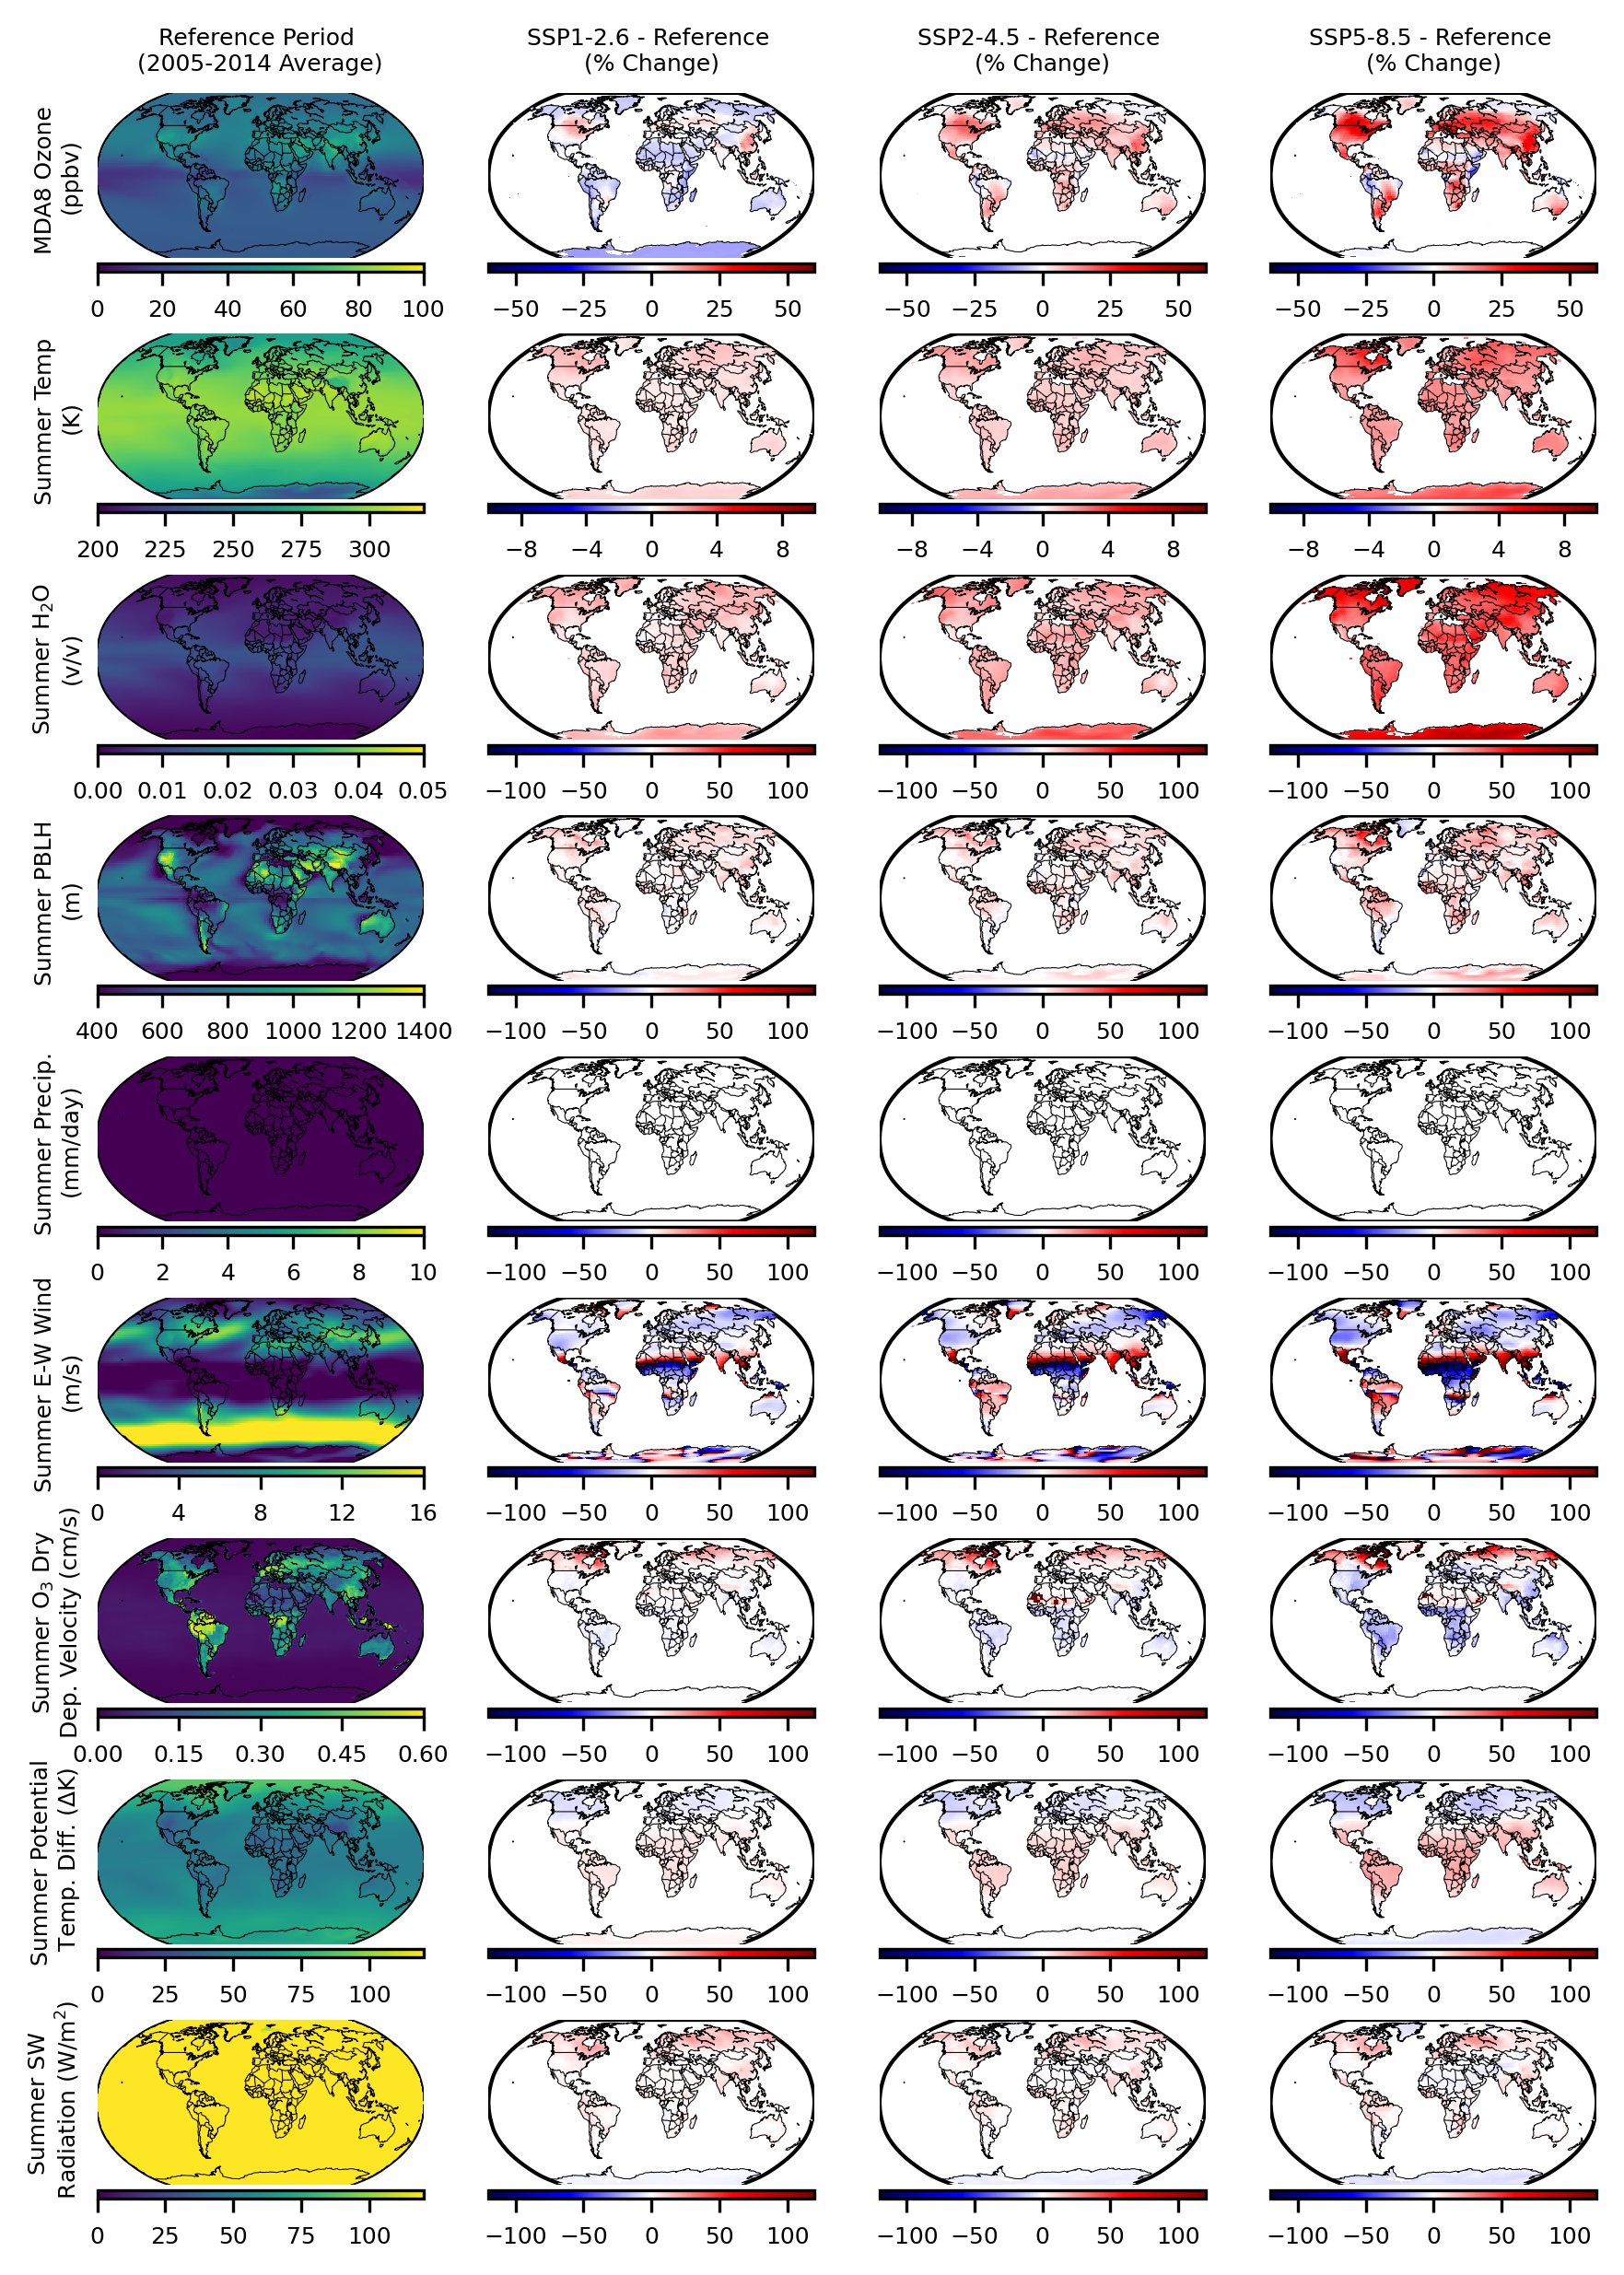

In [738]:
# NOW THE CESM OZONE DATA

# Plot Ozone results

#SSP126, 245, 585 vs ozone, temp, pblh, precip, dry dep, biogenics, E-W wind

#1 Read in Met data files
# calculate the delta relative to the base for each month?
# 2 Take summertime annual average of the deltas for NH and SH, then stick back together
# 3) then plot the resulting deltas and show compared to ozone results? (need to use 0.5x0.5 meshgrid, as well as a 2x2.5 meshgrid). 

#GISS ozone plots
path_iec = 'C:/Users/EMCDUF01/Industrial Economics, Inc/IEc EPA CSIB Share - IEc EPA CSIB Share/03_Global_AQ_Study/Data'
list_of_files = ['/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.base.nc', 
                '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim126.2090s.nc','/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim245.2090s.nc',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim585.2090s.nc',
                 '/GCAP2-CESM2_Raw Data/GEOSChem.CESM2.StateMet.base.ymonmean.nc4',
                 '/GCAP2-CESM2_Raw Data/GEOSChem.CESM2.StateMet.clim126.2090s.ymonmean.nc4',
                 '/GCAP2-CESM2_Raw Data/GEOSChem.CESM2.StateMet.clim245.2090s.ymonmean.nc4',
                '/GCAP2-CESM2_Raw Data/GEOSChem.CESM2.StateMet.clim585.2090s.ymonmean.nc4',
                '/GCAP2-CESM2_Raw Data/GC.CESM2.DryDep.base.nc',
                '/GCAP2-CESM2_Raw Data/GC.CESM2.DryDep.clim126.nc',
                '/GCAP2-CESM2_Raw Data/GC.CESM2.DryDep.clim245.nc',
                '/GCAP2-CESM2_Raw Data/GC.CESM2.DryDep.clim585.nc',]

data = Dataset(path_iec+list_of_files[0])
base_ozone_cesm = data.variables['MDA8'][0,0,:,:]
#data = Dataset(path_iec+list_of_files[1])
#base_ozone_giss = data.variables['corrected'][:,:]

data = Dataset(path_iec+list_of_files[4])
#print(data.variables)
#print(np.shape(latarray))

TS = data.variables['Met_TS']
TS_NH = np.ma.getdata(np.transpose(np.mean(TS[3:8,:,:], axis = 0)))
TS_SH = np.ma.getdata(np.transpose(np.mean(TS[[0,1,2,9,10,11],:,:], axis = 0)))
TS_NH = np.where((latarray >= 0), TS_NH, 0)
TS_SH = np.where((latarray < 0), TS_SH, 0)
TS_summer_base = TS_NH + TS_SH

TropLevel = data.variables['Met_TropLev'] #global average trop level is 23 (can make more specific mask later)
Wind = data.variables['Met_U']
#print(np.shape(Wind))
Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[3:8,0:20,:,:], axis = (0,1))))
Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
Wind_SH = np.where((latarray < 0), Wind_SH, 0)
Wind_summer_base = Wind_NH + Wind_SH

PBLH = data.variables['Met_PBLH']
PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[3:8,:,:], axis = 0)))
PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[[0,1,2,9,10,11],:,:], axis = 0)))
PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
PBLH_summer_base = PBLH_NH + PBLH_SH

Precip = data.variables['Met_PRECTOT']
Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[3:8,:,:], axis = 0)))
Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[[0,1,2,9,10,11],:,:], axis = 0)))
Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
Precip_SH = np.where((latarray < 0), Precip_SH, 0)
Precip_summer_base = Precip_NH + Precip_SH

H2O = data.variables['Met_AVGW']
H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[3:8,0:20,:,:], axis = (0,1))))
H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
H2O_SH = np.where((latarray < 0), H2O_SH, 0)
H2O_summer_base = H2O_NH + H2O_SH

#get the difference of potential temperature in the troposphere as an indicator of stagnation
Theta = data.variables['Met_THETA']
Theta_NH = np.ma.getdata(np.transpose(np.mean(Theta[3:8,17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(Theta[3:8,0,:,:], axis = 0)))
Theta_SH = np.ma.getdata(np.transpose(np.mean(Theta[[0,1,2,9,10,11],17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(Theta[[0,1,2,9,10,11],0,:,:], axis = 0)))
Theta_NH = np.where((latarray >= 0), Theta_NH, 0)
Theta_SH = np.where((latarray < 0), Theta_SH, 0)
Theta_summer_base = Theta_NH + Theta_SH

#Incident shortwave radiation at ground (W/m2)
SW = data.variables['Met_SWGDN']
SW_NH = np.ma.getdata(np.transpose(np.mean(SW[3:8,:,:], axis = 0)))
SW_SH = np.ma.getdata(np.transpose(np.mean(SW[[0,1,2,9,10,11],:,:], axis = 0)))
SW_NH = np.where((latarray >= 0), SW_NH, 0)
SW_SH = np.where((latarray < 0), SW_SH, 0)
SW_summer_base = SW_NH + SW_SH

data = Dataset(path_iec+list_of_files[8])
drydep = data.variables['DryDepVel_O3']
drydep_NH = np.ma.getdata(np.transpose(np.mean(drydep[3:8,:,:], axis = 0)))
drydep_SH = np.ma.getdata(np.transpose(np.mean(drydep[[0,1,2,9,10,11],:,:], axis = 0)))
drydep_NH = np.where((latarray >= 0), drydep_NH, 0)
drydep_SH = np.where((latarray < 0), drydep_SH, 0)
drydep_summer_base = drydep_NH + drydep_SH

numplts=36
# w x H
fig = plt.figure(dpi=300,figsize=(7,10))

for iplt in np.arange(0,numplts):
    ax = fig.add_subplot(9,4,iplt+1)
    m = Basemap(projection='robin',lon_0=0,resolution='c')
    m.drawmapboundary(fill_color='White')
    m.drawcoastlines(linewidth=0.25,zorder=3)
    m.drawcountries(linewidth=0.25,zorder=3)
    xpi25,ypi2 = m(xp25,yp2)
    xpi,ypi = m(xp,yp)

    #data = Dataset(path_iec+list_of_files[iplt])

    if ((iplt == 0)):
        data = np.transpose(base_ozone_cesm)
        #print(np.shape(base_ozone_giss))
        #print(np.shape(xpi))
        plot = m.pcolor(xpi,ypi,data, vmin=0, vmax=100, snap=True,zorder=2)
    elif ((iplt == 1) or (iplt == 2) or (iplt == 3)):
        data = Dataset(path_iec+list_of_files[iplt])
        data = 100*(data.variables['MDA8'][0,0,:,:] - base_ozone_cesm)/base_ozone_cesm
        print(np.shape(landmask2d), np.shape(data))
        data = np.ma.array(data,mask =~np.transpose(landmask2d))
        print('Average change O3: ',+np.mean(data))
        plot = m.pcolor(xpi,ypi,np.transpose(data), vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
    elif ((iplt ==4)):
        data = Dataset(path_iec+list_of_files[iplt])
        TS = data.variables['Met_TS']
        TS_NH = np.ma.getdata(np.transpose(np.mean(TS[3:8,:,:], axis = 0)))
        TS_SH = np.ma.getdata(np.transpose(np.mean(TS[[0,1,2,9,10,11],:,:], axis = 0)))
        TS_NH = np.where((latarray >= 0), TS_NH, 0)
        TS_SH = np.where((latarray < 0), TS_SH, 0)
        TS_summer = TS_NH + TS_SH
        plot = m.pcolor(xpi25,ypi2,TS_summer, vmin=200, vmax=320, snap=True,zorder=2)
    elif ((iplt >= 5) and (iplt <8)):
        data = Dataset(path_iec+list_of_files[iplt])
        TS = data.variables['Met_TS']
        TS_NH = np.ma.getdata(np.transpose(np.mean(TS[3:8,:,:], axis = 0)))
        TS_SH = np.ma.getdata(np.transpose(np.mean(TS[[0,1,2,9,10,11],:,:], axis = 0)))
        TS_NH = np.where((latarray >= 0), TS_NH, 0)
        TS_SH = np.where((latarray < 0), TS_SH, 0)
        TS_summer = TS_NH + TS_SH
        TS_summer = 100*(TS_summer - TS_summer_base)/TS_summer_base
        data = np.ma.array(TS_summer,mask =~landmask2x25)
        print('Average change Temp: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-10, vmax=10, snap=True,zorder=2, cmap = 'seismic')
    elif ((iplt ==8)):
        #print('base: '+list_of_files[iplt-4])
        data = Dataset(path_iec+list_of_files[iplt-4])
        H2O = data.variables['Met_AVGW']
        H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[3:8,0:20,:,:], axis = (0,1))))
        H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
        H2O_SH = np.where((latarray < 0), H2O_SH, 0)
        H2O_summer = H2O_NH + H2O_SH
        plot = m.pcolor(xpi25,ypi2,H2O_summer, vmin=0, vmax=0.05, snap=True,zorder=2)
    elif ((iplt >= 9) and (iplt < 12)):
        #print(list_of_files[iplt-4])
        data = Dataset(path_iec+list_of_files[iplt-4])
        H2O = data.variables['Met_AVGW']
        H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[3:8,0:20,:,:], axis = (0,1))))
        H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
        H2O_SH = np.where((latarray < 0), H2O_SH, 0)
        H2O_summer = H2O_NH + H2O_SH
        H2O_summer = 100*(H2O_summer - H2O_summer_base)/H2O_summer_base
        data = np.ma.array(H2O_summer,mask =~landmask2x25)
        print('Average change H2O: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
    elif ((iplt ==12)):
        #print(list_of_files[iplt-8])
        data = Dataset(path_iec+list_of_files[iplt-8])
        PBLH = data.variables['Met_PBLH']
        PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[3:8,:,:], axis = 0)))
        PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[[0,1,2,9,10,11],:,:], axis = 0)))
        PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
        PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
        PBLH_summer = PBLH_NH + PBLH_SH
        plot = m.pcolor(xpi25,ypi2,PBLH_summer, vmin=400, vmax=1400, snap=True,zorder=2)
    elif ((iplt >= 13) and (iplt < 16)):
        #print(list_of_files[iplt-8])
        data = Dataset(path_iec+list_of_files[iplt-8])
        PBLH = data.variables['Met_PBLH']
        PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[3:8,:,:], axis = 0)))
        PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[[0,1,2,9,10,11],:,:], axis = 0)))
        PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
        PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
        PBLH_summer = PBLH_NH + PBLH_SH
        PBLH_summer = 100*(PBLH_summer - PBLH_summer_base)/PBLH_summer_base
        data = np.ma.array(PBLH_summer,mask =~landmask2x25)
        print('Average change PBLH: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
    elif (iplt ==16):
        #print(list_of_files[iplt-12])
        data = Dataset(path_iec+list_of_files[iplt-12])
        Precip = data.variables['Met_PRECTOT']
        Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[3:8,:,:], axis = 0)))
        Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[[0,1,2,9,10,11],:,:], axis = 0)))
        Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
        Precip_SH = np.where((latarray < 0), Precip_SH, 0)
        Precip_summer = Precip_NH + Precip_SH
        #Precip_summer = np.where(Precip_summer ==0, Precip_summer, NaN)
        plot = m.pcolor(xpi25,ypi2,Precip_summer, vmin=0, vmax=10, snap=True,zorder=2)
    elif ((iplt >= 17) and (iplt < 20)):
        #print(list_of_files[iplt-12])
        data = Dataset(path_iec+list_of_files[iplt-12])
        Precip = data.variables['Met_PRECTOT']
        Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[3:8,:,:], axis = 0)))
        Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[[0,1,2,9,10,11],:,:], axis = 0)))
        Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
        Precip_SH = np.where((latarray < 0), Precip_SH, 0)
        Precip_summer = Precip_NH + Precip_SH
        Precip_summer = 100*(Precip_summer - Precip_summer_base)/Precip_summer_base
        data = np.ma.array(Precip_summer,mask =~landmask2x25)
        print('Average change Precip: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
    elif (iplt ==20):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        Wind = data.variables['Met_U']
        Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[3:8,0:20,:,:], axis = (0,1))))
        Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
        Wind_SH = np.where((latarray < 0), Wind_SH, 0)
        Wind_summer = Wind_NH + Wind_SH
        plot = m.pcolor(xpi25,ypi2,Wind_summer_base, vmin=0, vmax=16, snap=True,zorder=2)
    elif ((iplt >= 21) and (iplt < 24)):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        Wind = data.variables['Met_U']
        Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[3:8,0:20,:,:], axis = (0,1))))
        Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
        Wind_SH = np.where((latarray < 0), Wind_SH, 0)
        Wind_summer = Wind_NH + Wind_SH
        Wind_summer = 100*(Wind_summer - Wind_summer_base)/Wind_summer_base
        data = np.ma.array(Wind_summer,mask =~landmask2x25)
        print('Average change Wind: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
    elif (iplt==24):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        drydep = data.variables['DryDepVel_O3']
        drydep_NH = np.ma.getdata(np.transpose(np.mean(drydep[3:8,:,:], axis = 0)))
        drydep_SH = np.ma.getdata(np.transpose(np.mean(drydep[[0,1,2,9,10,11],:,:], axis = 0)))
        drydep_NH = np.where((latarray >= 0), drydep_NH, 0)
        drydep_SH = np.where((latarray < 0), drydep_SH, 0)
        drydep_summer = drydep_NH + drydep_SH
        plot = m.pcolor(xpi25,ypi2,drydep_summer, vmin=0, vmax=0.6, snap=True,zorder=2)
    elif ((iplt >= 25) and (iplt < 28)):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        drydep = data.variables['DryDepVel_O3']
        drydep_NH = np.ma.getdata(np.transpose(np.mean(drydep[3:8,:,:], axis = 0)))
        drydep_SH = np.ma.getdata(np.transpose(np.mean(drydep[[0,1,2,9,10,11],:,:], axis = 0)))
        drydep_NH = np.where((latarray >= 0), drydep_NH, 0)
        drydep_SH = np.where((latarray < 0), drydep_SH, 0)
        drydep_summer = drydep_NH + drydep_SH
        drydep_summer = 100*(drydep_summer - drydep_summer_base)/drydep_summer_base
        data = np.ma.array(drydep_summer,mask =~landmask2x25)
        print('Average change Dry Dep: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
    elif (iplt==28):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-24])
        theta = data.variables['Met_THETA']
        theta_NH = np.ma.getdata(np.transpose(np.mean(Theta[3:8,17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(Theta[3:8,0,:,:], axis = 0)))
        theta_SH = np.ma.getdata(np.transpose(np.mean(Theta[[0,1,2,9,10,11],17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(Theta[[0,1,2,9,10,11],0,:,:], axis = 0)))
        theta_NH = np.where((latarray >= 0), theta_NH, 0)
        theta_SH = np.where((latarray < 0), theta_SH, 0)
        theta_summer = theta_NH + theta_SH
        plot = m.pcolor(xpi25,ypi2,theta_summer, vmin=0, vmax=120, snap=True,zorder=2)
    elif ((iplt >= 29) and (iplt < 32)):
        data = Dataset(path_iec+list_of_files[iplt-24])
        theta = data.variables['Met_THETA']
        theta_NH = np.ma.getdata(np.transpose(np.mean(theta[3:8,17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(theta[3:8,0,:,:], axis = 0)))
        theta_SH = np.ma.getdata(np.transpose(np.mean(theta[[0,1,2,9,10,11],17,:,:], axis = 0)))-np.ma.getdata(np.transpose(np.mean(theta[[0,1,2,9,10,11],0,:,:], axis = 0)))
        theta_NH = np.where((latarray >= 0), theta_NH, 0)
        theta_SH = np.where((latarray < 0), theta_SH, 0)
        print(np.max(theta_SH), np.max(theta_NH), np.max(Theta_summer_base))
        theta_summer = theta_NH + theta_SH
        theta_summer = 100*(theta_summer - Theta_summer_base)/Theta_summer_base
        data = np.ma.array(theta_summer,mask =~landmask2x25)
        print('Average change Theta: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')
    elif (iplt==32):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-28])
        SW = data.variables['Met_SWGDN']
        SW_NH = np.ma.getdata(np.transpose(np.mean(SW[3:8,:,:], axis = 0)))
        SW_SH = np.ma.getdata(np.transpose(np.mean(SW[[0,1,2,9,10,11],:,:], axis = 0)))
        SW_NH = np.where((latarray >= 0), SW_NH, 0)
        SW_SH = np.where((latarray < 0), SW_SH, 0)
        SW_summer = SW_NH + SW_SH
        plot = m.pcolor(xpi25,ypi2,SW_summer, vmin=0, vmax=120, snap=True,zorder=2)
    elif ((iplt >= 33) and (iplt < 36)):
        data = Dataset(path_iec+list_of_files[iplt-28])
        SW = data.variables['Met_SWGDN']
        SW_NH = np.ma.getdata(np.transpose(np.mean(SW[3:8,:,:], axis = 0)))
        SW_SH = np.ma.getdata(np.transpose(np.mean(SW[[0,1,2,9,10,11],:,:], axis = 0)))
        SW_NH = np.where((latarray >= 0), SW_NH, 0)
        SW_SH = np.where((latarray < 0), SW_SH, 0)
        SW_summer = SW_NH + SW_SH
        SW_summer = 100*(SW_summer - SW_summer_base)/SW_summer_base
        data = np.ma.array(SW_summer,mask =~landmask2x25)
        print('Average change SW at Ground: ',+np.mean(data))
        plot = m.pcolor(xpi25,ypi2,data, vmin=-120, vmax=120, snap=True,zorder=2, cmap = 'seismic')

    if ((iplt ==0)):
        ax.set_title('Reference Period \n(2005-2014 Average)',fontsize=6)
    elif iplt ==1:
        ax.set_title('SSP1-2.6 - Reference \n(% Change)',fontsize=6)
    elif iplt ==2:
        ax.set_title('SSP2-4.5 - Reference \n(% Change)',fontsize=6)
    elif iplt ==3:
        ax.set_title('SSP5-8.5 - Reference \n(% Change)',fontsize=6)

    cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    #if  ((iplt ==0) or (iplt ==1)):
    #    cb.ax.set_xlabel('$\Delta$MDA8 O$_{3}$ (ppbv)',fontsize=5)
    #elif ((iplt ==2) or (iplt ==3)):
    #    cb.ax.set_xlabel('$\Delta$Annual Average PM$_{2.5}$ ($\\mu$gm$^{-3}$)',fontsize=5)
    cb.ax.tick_params(labelsize=6)
    if iplt ==0:
        plt.ylabel('MDA8 Ozone \n(ppbv)',fontsize=6)
    elif iplt ==4:
        plt.ylabel('Summer Temp \n(K)',fontsize=6)
    elif iplt ==8:
        plt.ylabel('Summer H$_2$O \n(v/v)',fontsize=6)
    elif iplt ==12:
        plt.ylabel('Summer PBLH \n(m)',fontsize=6)   
    elif iplt ==16:
        plt.ylabel('Summer Precip. \n(mm/day)',fontsize=6)
    elif iplt ==20:
        plt.ylabel('Summer E-W Wind \n(m/s)',fontsize=6)
    elif iplt ==24:
        plt.ylabel('Summer O$_3$ Dry \nDep. Velocity (cm/s)',fontsize=6)
    elif iplt ==28:
        plt.ylabel('Summer Potential\n Temp. Diff. ($\Delta$K)',fontsize=6)
    elif iplt ==32:
        plt.ylabel('Summer SW\n Radiation (W/m$^2$)',fontsize=6)

plt.savefig('FigureS4_summer_cesm_ozone_maps.png', bbox_inches='tight')
plt.show();

C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2487243462.py:135: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=0, vmax=100, snap=True,zorder=2)


(144, 90) (144, 90)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2487243462.py:150: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2487243462.py:151: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


(144, 90) (144, 90)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2487243462.py:150: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2487243462.py:151: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')


(144, 90) (144, 90)


C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2487243462.py:150: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plot = m.pcolor(xpi25,ypi2,data, vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2487243462.py:151: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
C:\Users\EMCDUF01\AppData\Local\Temp\ipykernel_23856\2487243462.py:164: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell e

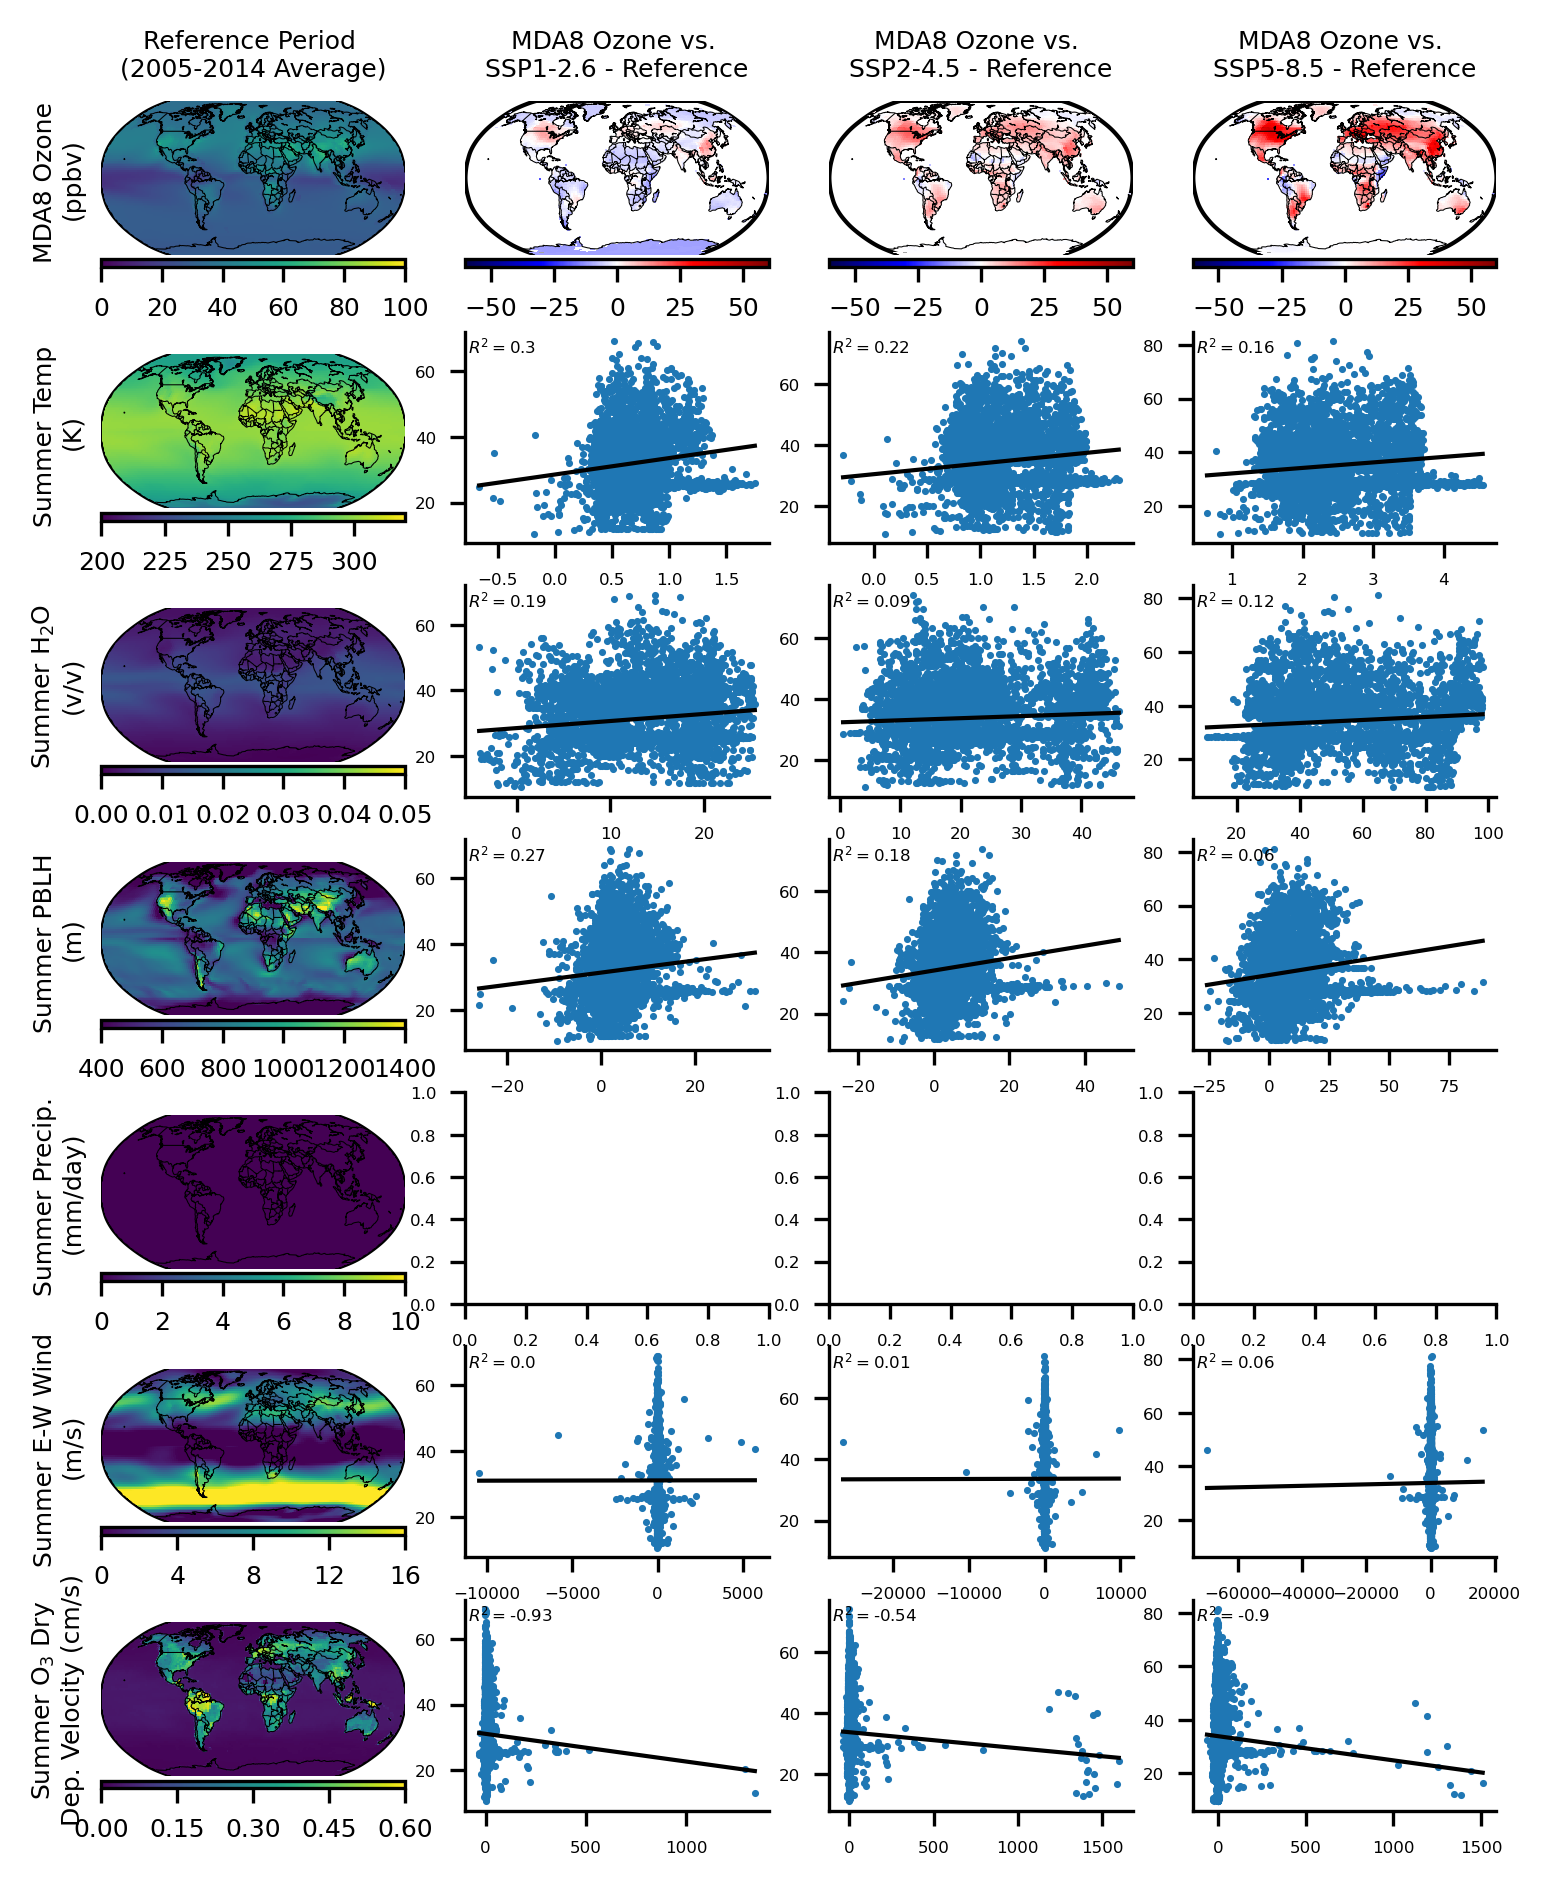

In [712]:
# CESM regression plots

# Plot Ozone results

#SSP126, 245, 585 vs ozone, temp, pblh, precip, dry dep, biogenics, E-W wind

#1 Read in Met data files
# calculate the delta relative to the base for each month?
# 2 Take summertime annual average of the deltas for NH and SH, then stick back together
# 3) then plot the resulting deltas and show compared to ozone results? (need to use 0.5x0.5 meshgrid, as well as a 2x2.5 meshgrid). 

#GISS ozone plots
path_iec = 'C:/Users/EMCDUF01/Industrial Economics, Inc/IEc EPA CSIB Share - IEc EPA CSIB Share/03_Global_AQ_Study/Data'
list_of_files = ['/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.base.nc', 
                '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim126.2090s.nc','/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim245.2090s.nc',
                 '/GCAP2-CESM2_Raw Data/GCAP2-CESM2/OSDMA8.clim585.2090s.nc',
                 '/GCAP2-CESM2_Raw Data/GEOSChem.CESM2.StateMet.base.ymonmean.nc4',
                 '/GCAP2-CESM2_Raw Data/GEOSChem.CESM2.StateMet.clim126.2090s.ymonmean.nc4',
                 '/GCAP2-CESM2_Raw Data/GEOSChem.CESM2.StateMet.clim245.2090s.ymonmean.nc4',
                '/GCAP2-CESM2_Raw Data/GEOSChem.CESM2.StateMet.clim585.2090s.ymonmean.nc4',
                '/GCAP2-CESM2_Raw Data/GC.CESM2.DryDep.base.nc',
                '/GCAP2-CESM2_Raw Data/GC.CESM2.DryDep.clim126.nc',
                '/GCAP2-CESM2_Raw Data/GC.CESM2.DryDep.clim245.nc',
                '/GCAP2-CESM2_Raw Data/GC.CESM2.DryDep.clim585.nc',]

#regionmask
#region_mask = usamask2x25
region_mask = landmask2x25

#re-grid the ozone data to the 2x2.5 resolution of the met data (alternatively could have regridded the met data...)
data_ozone = xr.open_dataset(path_iec+list_of_files[0])
data = Dataset(path_iec+list_of_files[4])
regrid_lat = data.variables['lat']
regrid_lon = data.variables['lon']
regridded_data = data_ozone.interp(lat=regrid_lat,lon=regrid_lon,method ='linear')
base_ozone_cesm = regridded_data.variables['MDA8'][0,0,:,:].transpose()
#print(np.shape(base_ozone_cesm))
data_ozone = xr.open_dataset(path_iec+list_of_files[1])
regridded_data = data_ozone.interp(lat=regrid_lat,lon=regrid_lon,method ='linear')
ssp126_ozone_cesm = regridded_data.variables['MDA8'][0,0,:,:].transpose()
data_ozone = xr.open_dataset(path_iec+list_of_files[2])
regridded_data = data_ozone.interp(lat=regrid_lat,lon=regrid_lon,method ='linear')
ssp245_ozone_cesm = regridded_data.variables['MDA8'][0,0,:,:].transpose()
data_ozone = xr.open_dataset(path_iec+list_of_files[3])
regridded_data = data_ozone.interp(lat=regrid_lat,lon=regrid_lon,method ='linear')
ssp585_ozone_cesm = regridded_data.variables['MDA8'][0,0,:,:].transpose()
#data = Dataset(path_iec+list_of_files[1])
#base_ozone_giss = data.variables['corrected'][:,:]

#these data are at 2x2.5 resolution (the resolution of the GCMs)
data = Dataset(path_iec+list_of_files[4])
#print(data.variables)
#print(np.shape(latarray))

TS = data.variables['Met_TS']
TS_NH = np.ma.getdata(np.transpose(np.mean(TS[3:8,:,:], axis = 0)))
TS_SH = np.ma.getdata(np.transpose(np.mean(TS[[0,1,2,9,10,11],:,:], axis = 0)))
TS_NH = np.where((latarray >= 0), TS_NH, 0)
TS_SH = np.where((latarray < 0), TS_SH, 0)
TS_summer_base = TS_NH + TS_SH

TropLevel = data.variables['Met_TropLev'] #global average trop level is 23 (can make more specific mask later)
Wind = data.variables['Met_U']
#print(np.shape(Wind))
Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[3:8,0:20,:,:], axis = (0,1))))
Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
Wind_SH = np.where((latarray < 0), Wind_SH, 0)
Wind_summer_base = Wind_NH + Wind_SH

PBLH = data.variables['Met_PBLH']
PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[3:8,:,:], axis = 0)))
PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[[0,1,2,9,10,11],:,:], axis = 0)))
PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
PBLH_summer_base = PBLH_NH + PBLH_SH

Precip = data.variables['Met_PRECTOT']
Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[3:8,:,:], axis = 0)))
Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[[0,1,2,9,10,11],:,:], axis = 0)))
Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
Precip_SH = np.where((latarray < 0), Precip_SH, 0)
Precip_summer_base = Precip_NH + Precip_SH

H2O = data.variables['Met_AVGW']
H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[3:8,0:20,:,:], axis = (0,1))))
H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
H2O_SH = np.where((latarray < 0), H2O_SH, 0)
H2O_summer_base = H2O_NH + H2O_SH

data = Dataset(path_iec+list_of_files[8])
drydep = data.variables['DryDepVel_O3']
drydep_NH = np.ma.getdata(np.transpose(np.mean(drydep[3:8,:,:], axis = 0)))
drydep_SH = np.ma.getdata(np.transpose(np.mean(drydep[[0,1,2,9,10,11],:,:], axis = 0)))
drydep_NH = np.where((latarray >= 0), drydep_NH, 0)
drydep_SH = np.where((latarray < 0), drydep_SH, 0)
drydep_summer_base = drydep_NH + drydep_SH

numplts=28
fig = plt.figure(dpi=300,figsize=(6,7.5))

for iplt in np.arange(0,numplts):
    ax = fig.add_subplot(7,4,iplt+1)
    #m = Basemap(projection='robin',lon_0=0,resolution='c')
    #m.drawmapboundary(fill_color='White')
    #m.drawcoastlines(linewidth=0.25,zorder=3)
    #m.drawcountries(linewidth=0.25,zorder=3)
    #xpi25,ypi2 = m(xp25,yp2)
    #xpi,ypi = m(xp,yp)

    #data = Dataset(path_iec+list_of_files[iplt])

    if ((iplt <= 4) or (iplt == 8) or (iplt ==12) or (iplt==16) or (iplt==20) or (iplt==24)):
        m = Basemap(projection='robin',lon_0=0,resolution='c')
        m.drawmapboundary(fill_color='White')
        m.drawcoastlines(linewidth=0.25,zorder=3)
        m.drawcountries(linewidth=0.25,zorder=3)
        xpi25,ypi2 = m(xp25,yp2)
        xpi,ypi = m(xp,yp)

    # need to transpose the ozone data back to lonxlat for the scatter plots
    if ((iplt ==5) or (iplt == 9) or (iplt==13) or (iplt ==17) or (iplt ==21) or (iplt==25)):
        y = ssp126_ozone_cesm.transpose()
        y=y.values.flatten()
    elif ((iplt ==6) or (iplt == 10) or (iplt==14) or (iplt ==18) or (iplt ==22) or (iplt==26)):
        y = ssp245_ozone_cesm.transpose()
        y=y.values.flatten()
    elif ((iplt ==7) or (iplt == 11) or (iplt==15) or (iplt ==19) or (iplt ==23) or (iplt==27)):
        y = ssp585_ozone_cesm.transpose()
        y=y.values.flatten()
                             
    if ((iplt == 0)):
        data = base_ozone_cesm
        plot = m.pcolor(xpi25,ypi2,data, vmin=0, vmax=100, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt == 1) or (iplt == 2) or (iplt == 3)):
        if iplt ==1:
            data = 100*(ssp126_ozone_cesm- base_ozone_cesm)/base_ozone_cesm
        elif iplt ==2:
            data = 100*(ssp245_ozone_cesm- base_ozone_cesm)/base_ozone_cesm
        elif iplt ==3:
            data = 100*(ssp585_ozone_cesm- base_ozone_cesm)/base_ozone_cesm
        print(np.shape(landmask2x25), np.shape(data))
        data = np.ma.array(data,mask =~landmask2x25)
        plot = m.pcolor(xpi25,ypi2,data, vmin=-60, vmax=60, snap=True,zorder=2, cmap = 'seismic')
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt ==4)):
        data = Dataset(path_iec+list_of_files[iplt])
        TS = data.variables['Met_TS']
        TS_NH = np.ma.getdata(np.transpose(np.mean(TS[3:8,:,:], axis = 0)))
        TS_SH = np.ma.getdata(np.transpose(np.mean(TS[[0,1,2,9,10,11],:,:], axis = 0)))
        TS_NH = np.where((latarray >= 0), TS_NH, 0)
        TS_SH = np.where((latarray < 0), TS_SH, 0)
        TS_summer = TS_NH + TS_SH
        plot = m.pcolor(xpi25,ypi2,TS_summer, vmin=200, vmax=320, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt >= 5) and (iplt <8)):
        data = Dataset(path_iec+list_of_files[iplt])
        TS = data.variables['Met_TS']
        TS_NH = np.ma.getdata(np.transpose(np.mean(TS[3:8,:,:], axis = 0)))
        TS_SH = np.ma.getdata(np.transpose(np.mean(TS[[0,1,2,9,10,11],:,:], axis = 0)))
        TS_NH = np.where((latarray >= 0), TS_NH, 0)
        TS_SH = np.where((latarray < 0), TS_SH, 0)
        TS_summer = TS_NH + TS_SH
        TS_summer = 100*(TS_summer - TS_summer_base)/TS_summer_base
        data = np.ma.array(TS_summer,mask =~region_mask)
        x = data.flatten()
        plot = ax.scatter(x,y,s=0.5)
        b,a = np.polyfit(x,y, deg=1)
        xseq = np.linspace(np.min(x),np.max(x),num=len(x))
        reg = a+b*xseq
        r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
        ax.plot(xseq, reg, color='k', lw=1)
        ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)
    elif ((iplt ==8)):
        #print('base: '+list_of_files[iplt-4])
        data = Dataset(path_iec+list_of_files[iplt-4])
        H2O = data.variables['Met_AVGW']
        H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[3:8,0:20,:,:], axis = (0,1))))
        H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
        H2O_SH = np.where((latarray < 0), H2O_SH, 0)
        H2O_summer = H2O_NH + H2O_SH
        plot = m.pcolor(xpi25,ypi2,H2O_summer, vmin=0, vmax=0.05, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt >= 9) and (iplt < 12)):
        #print(list_of_files[iplt-4])
        data = Dataset(path_iec+list_of_files[iplt-4])
        H2O = data.variables['Met_AVGW']
        H2O_NH = np.ma.getdata(np.transpose(np.mean(H2O[3:8,0:20,:,:], axis = (0,1))))
        H2O_SH = np.ma.getdata(np.transpose(np.mean(H2O[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        H2O_NH = np.where((latarray >= 0), H2O_NH, 0)
        H2O_SH = np.where((latarray < 0), H2O_SH, 0)
        H2O_summer = H2O_NH + H2O_SH
        H2O_summer = 100*(H2O_summer - H2O_summer_base)/H2O_summer_base
        data = np.ma.array(H2O_summer,mask =~region_mask)
        x = data.flatten()
        plot = ax.scatter(x,y,s=0.5)
        b,a = np.polyfit(x,y, deg=1)
        xseq = np.linspace(np.min(x),np.max(x),num=len(x))
        reg = a+b*xseq
        r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
        ax.plot(xseq, reg, color='k', lw=1)
        ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)
    elif ((iplt ==12)):
        #print(list_of_files[iplt-8])
        data = Dataset(path_iec+list_of_files[iplt-8])
        PBLH = data.variables['Met_PBLH']
        PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[3:8,:,:], axis = 0)))
        PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[[0,1,2,9,10,11],:,:], axis = 0)))
        PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
        PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
        PBLH_summer = PBLH_NH + PBLH_SH
        plot = m.pcolor(xpi25,ypi2,PBLH_summer, vmin=400, vmax=1400, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt >= 13) and (iplt < 16)):
        #print(list_of_files[iplt-8])
        data = Dataset(path_iec+list_of_files[iplt-8])
        PBLH = data.variables['Met_PBLH']
        PBLH_NH = np.ma.getdata(np.transpose(np.mean(PBLH[3:8,:,:], axis = 0)))
        PBLH_SH = np.ma.getdata(np.transpose(np.mean(PBLH[[0,1,2,9,10,11],:,:], axis = 0)))
        PBLH_NH = np.where((latarray >= 0), PBLH_NH, 0)
        PBLH_SH = np.where((latarray < 0), PBLH_SH, 0)
        PBLH_summer = PBLH_NH + PBLH_SH
        PBLH_summer = 100*(PBLH_summer - PBLH_summer_base)/PBLH_summer_base
        data = np.ma.array(PBLH_summer,mask =~region_mask)
        x = data.flatten()
        plot = ax.scatter(x,y,s=0.5)
        b,a = np.polyfit(x,y, deg=1)
        xseq = np.linspace(np.min(x),np.max(x),num=len(x))
        reg = a+b*xseq
        r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
        ax.plot(xseq, reg, color='k', lw=1)
        ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)
    elif (iplt ==16):
        #print(list_of_files[iplt-12])
        data = Dataset(path_iec+list_of_files[iplt-12])
        Precip = data.variables['Met_PRECTOT']
        Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[3:8,:,:], axis = 0)))
        Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[[0,1,2,9,10,11],:,:], axis = 0)))
        Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
        Precip_SH = np.where((latarray < 0), Precip_SH, 0)
        Precip_summer = Precip_NH + Precip_SH
        #Precip_summer = np.where(Precip_summer ==0, Precip_summer, NaN)
        plot = m.pcolor(xpi25,ypi2,Precip_summer, vmin=0, vmax=10, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    #elif ((iplt >= 17) and (iplt < 20)):
    #    pass
    #    #print(list_of_files[iplt-12])
    #    data = Dataset(path_iec+list_of_files[iplt-12])
    #    Precip = data.variables['Met_PRECTOT']
    #    Precip_NH = np.ma.getdata(np.transpose(np.mean(Precip[3:8,:,:], axis = 0)))
    #    Precip_SH = np.ma.getdata(np.transpose(np.mean(Precip[[0,1,2,9,10,11],:,:], axis = 0)))
    #    Precip_NH = np.where((latarray >= 0), Precip_NH, 0)
    #    Precip_SH = np.where((latarray < 0), Precip_SH, 0)
    #    Precip_summer = Precip_NH + Precip_SH
    #    Precip_summer = 100*(Precip_summer - Precip_summer_base)/Precip_summer_base
    #    data = np.ma.array(Precip_summer,mask =~region_mask)
    #    x = data.flatten()
    #    plot = ax.scatter(x,y,s=0.5)
    #    b,a = np.polyfit(x,y, deg=1)
    #    xseq = np.linspace(np.min(x),np.max(x),num=len(x))
    #    reg = a+b*xseq
    #    r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
    #    ax.plot(xseq, reg, color='k', lw=1)
    #    ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)
    elif (iplt ==20):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        Wind = data.variables['Met_U']
        Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[3:8,0:20,:,:], axis = (0,1))))
        Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
        Wind_SH = np.where((latarray < 0), Wind_SH, 0)
        Wind_summer = Wind_NH + Wind_SH
        plot = m.pcolor(xpi25,ypi2,Wind_summer, vmin=0, vmax=16, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt >= 21) and (iplt < 24)):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        Wind = data.variables['Met_U']
        Wind_NH = np.ma.getdata(np.transpose(np.mean(Wind[3:8,0:20,:,:], axis = (0,1))))
        Wind_SH = np.ma.getdata(np.transpose(np.mean(Wind[[0,1,2,9,10,11],0:20,:,:], axis = (0,1))))
        Wind_NH = np.where((latarray >= 0), Wind_NH, 0)
        Wind_SH = np.where((latarray < 0), Wind_SH, 0)
        Wind_summer = Wind_NH + Wind_SH
        Wind_summer = 100*(Wind_summer - Wind_summer_base)/Wind_summer_base
        data = np.ma.array(Wind_summer,mask =~region_mask)
        x = data.flatten()
        plot = ax.scatter(x,y,s=0.5)
        b,a = np.polyfit(x,y, deg=1)
        xseq = np.linspace(np.min(x),np.max(x),num=len(x))
        reg = a+b*xseq
        r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
        ax.plot(xseq, reg, color='k', lw=1)
        ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)
    elif (iplt==24):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        drydep = data.variables['DryDepVel_O3']
        drydep_NH = np.ma.getdata(np.transpose(np.mean(drydep[3:8,:,:], axis = 0)))
        drydep_SH = np.ma.getdata(np.transpose(np.mean(drydep[[0,1,2,9,10,11],:,:], axis = 0)))
        drydep_NH = np.where((latarray >= 0), drydep_NH, 0)
        drydep_SH = np.where((latarray < 0), drydep_SH, 0)
        drydep_summer = drydep_NH + drydep_SH
        #drydep_summer = np.ma.array(drydep_summer,mask =~region_mask)
        plot = m.pcolor(xpi25,ypi2,drydep_summer, vmin=0, vmax=0.6, snap=True,zorder=2)
        cb = m.colorbar(plot, location = "bottom", pad = "3%",size='5%')
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.ax.tick_params(labelsize=6)
    elif ((iplt >= 25) and (iplt < 28)):
        #print(list_of_files[iplt-16])
        data = Dataset(path_iec+list_of_files[iplt-16])
        drydep = data.variables['DryDepVel_O3']
        drydep_NH = np.ma.getdata(np.transpose(np.mean(drydep[3:8,:,:], axis = 0)))
        drydep_SH = np.ma.getdata(np.transpose(np.mean(drydep[[0,1,2,9,10,11],:,:], axis = 0)))
        drydep_NH = np.where((latarray >= 0), drydep_NH, 0)
        drydep_SH = np.where((latarray < 0), drydep_SH, 0)
        drydep_summer = drydep_NH + drydep_SH
        drydep_summer = 100*(drydep_summer - drydep_summer_base)/drydep_summer_base
        data = np.ma.array(drydep_summer,mask =~region_mask)
        x = data.flatten()
        plot = ax.scatter(x,y,s=0.5)
        b,a = np.polyfit(x,y, deg=1)
        xseq = np.linspace(np.min(x),np.max(x),num=len(x))
        reg = a+b*xseq
        r_squared = r'$R^2 =$' +str(round(r2_score(y, reg),2))
        ax.plot(xseq, reg, color='k', lw=1)
        ax.text(0.01,0.90,r_squared,fontsize=4,transform=ax.transAxes)

    if ((iplt ==0)):
        ax.set_title('Reference Period \n(2005-2014 Average)',fontsize=6)
    elif iplt ==1:
        ax.set_title('MDA8 Ozone vs. \nSSP1-2.6 - Reference',fontsize=6)
    elif iplt ==2:
        ax.set_title('MDA8 Ozone vs. \nSSP2-4.5 - Reference',fontsize=6)
    elif iplt ==3:
        ax.set_title('MDA8 Ozone vs. \nSSP5-8.5 - Reference',fontsize=6)


    if iplt ==0:
        plt.ylabel('MDA8 Ozone \n(ppbv)',fontsize=6)
    elif iplt ==4:
        plt.ylabel('Summer Temp \n(K)',fontsize=6)
    elif iplt ==8:
        plt.ylabel('Summer H$_2$O \n(v/v)',fontsize=6)
    elif iplt ==12:
        plt.ylabel('Summer PBLH \n(m)',fontsize=6)   
    elif iplt ==16:
        plt.ylabel('Summer Precip. \n(mm/day)',fontsize=6)
    elif iplt ==20:
        plt.ylabel('Summer E-W Wind \n(m/s)',fontsize=6)
    elif iplt ==24:
        plt.ylabel('Summer O$_3$ Dry \nDep. Velocity (cm/s)',fontsize=6)
    elif iplt >= 5:
        #plt.ylabel("ozone", fontsize=5)
        plt.tick_params(axis='both', labelsize=4)
        #ax.set_xticks([])
        #ax.set_yticks([])
        # Remove the border (spines)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        #ax.spines['left'].set_visible(False)

plt.savefig('FigureS4_summer_cesm_ozone_correlations.png', bbox_inches='tight')
plt.show();

In [736]:
data = Dataset(path_iec+list_of_files[4])
print(data.variables)

{'time': <class 'netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: Time
    bounds: time_bnds
    units: minutes since 2005-01-01 00:00:00
    calendar: gregorian
    axis: T
unlimited dimensions: time
current shape = (12,)
filling off, 'time_bnds': <class 'netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (12, 2)
filling off, 'lon': <class 'netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
    bounds: lon_bnds
unlimited dimensions: 
current shape = (144,)
filling off, 'lon_bnds': <class 'netCDF4.Variable'>
float64 lon_bnds(lon, bnds)
unlimited dimensions: 
current shape = (144, 2)
filling off, 'lat': <class 'netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
    bounds: lat_bnds
unlimited dimensions: 
current shape = (90,)
filling off, 'lat_bnds': <class 'netCDF4.Variab